True

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import beta
import itertools
from scipy import spatial
from collections import namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Run on GPU through metal device
device = torch.device('mps')

%load_ext line_profiler

In [2]:
class MultiArmedBandit:
    """
    Multi-armed bandit class.
    """

    def __init__(self, num_bandits: int, probs: np.ndarray, payouts: np.ndarray, bandit_type: str):
        self.num_bandits = num_bandits
        self.type = bandit_type
        self.probs = probs
        self.payouts = payouts

    def reset(self):
        if self.type == "Bernoulli":
            self.probs = np.random.rand(nr_bandits)
        elif self.type == "Normal":
            means = [np.random.randint(-10,10) for _ in range(nr_bandits)]
            scales = [np.random.randint(1,10) for _ in range(nr_bandits)]
            probs = [norm(means[i], scales[i]) for i in range(nr_bandits)]
        else:
            self.probs = np.random.rand(nr_bandits)
            self.payouts = [np.random.randint(1,10) for _ in range(nr_bandits)]
        
    def pull(self, i: int):
        if self.type == "Bernoulli":
            if np.random.rand() < self.probs[i]:
                return 1
            else:
                return 0
        elif self.type == "Normal":
            return self.probs[i].rvs()
        #if np.random.rand() < self.probs[i]:
        #    return self.payouts[i]
        #else:
        #    return 0

In [3]:
class EpsilonGreedy():
    def __init__(self, num_bandits: int, eps = 0.05, alpha = 1.0):
        self.num_bandits = num_bandits
        self.choices = []
        self.wins = np.zeros(num_bandits)
        self.pulls = np.zeros(num_bandits)
        self.initial_eps = eps
        self.eps = eps
        self.alpha = alpha
        
    def reset(self):
        self.choices = []
        self.eps = self.initial_eps
        self.wins = np.zeros(self.num_bandits)
        self.pulls = np.zeros(self.num_bandits)
        
    def max_mean(self):
        return np.argmax(self.wins / (self.pulls + 0.1))

    def choose(self):
        r = np.random.rand()

        if r < self.eps:
            return np.random.choice(
                list(set(range(len(self.wins))) - {self.max_mean()})
            )
        else:
            return self.max_mean()
        
    def process_choice(self, choice, payout):
        self.pulls[choice] += 1
        self.wins[choice] += payout
        self.choices.append(choice)
        self.eps *= self.alpha
        
    def print_average_reward(self):
        total_wins = float(sum(self.wins))
        total_pulls = float(sum(self.pulls))
        print("Total pulls: " + str(total_pulls))
        print("Total wins: " + str(total_wins))
        print(total_wins / total_pulls)

In [4]:
class UCB():
    def __init__(self, num_bandits: int):
        self.num_bandits = num_bandits
        self.choices = []
        self.wins = np.zeros(num_bandits)
        self.pulls = np.zeros(num_bandits)
        
    def reset(self):
        self.choices = []
        self.wins = np.zeros(self.num_bandits)
        self.pulls = np.zeros(self.num_bandits)
        
    def choose(self):
        if True in (self.pulls < 3):
            return np.random.choice(range(len(self.pulls)))
        else:
            n_total = sum(self.pulls)
            payouts = self.wins / (self.pulls + 0.1)
            ubcs = payouts + np.sqrt(
                2 * np.log(n_total) / self.pulls
            )

            return np.argmax(ubcs)
        
    def process_choice(self, choice, payout):
        self.pulls[choice] += 1
        self.wins[choice] += payout
        self.choices.append(choice)
        
    def print_average_reward(self):
        total_wins = float(sum(self.wins))
        total_pulls = float(sum(self.pulls))
        print("Total pulls: " + str(total_pulls))
        print("Total wins: " + str(total_wins))
        print(total_wins / total_pulls)

In [5]:
class ThompsonSampling():
    def __init__(self, num_bandits: int):
        self.num_bandits = num_bandits
        self.choices = []
        self.alphas = np.ones(num_bandits)
        self.betas = np.ones(num_bandits)
        self.wins = np.zeros(num_bandits)
        self.pulls = np.zeros(num_bandits)
        
    def reset(self):
        self.choices = []
        self.wins = np.zeros(self.num_bandits)
        self.pulls = np.zeros(self.num_bandits)
        self.alphas = np.ones(self.num_bandits)
        self.betas = np.ones(self.num_bandits)
        
    def choose(self):
        theta = np.random.beta(self.alphas, self.betas)
        return theta.argmax()
        
    def process_choice(self, choice, payout):
        self.pulls[choice] += 1
        self.wins[choice] += payout
        self.choices.append(choice)
        self.alphas[choice] += payout
        self.betas[choice] += 1 - payout
        
    def print_average_reward(self):
        total_wins = float(sum(self.wins))
        total_pulls = float(sum(self.pulls))
        print("Total pulls: " + str(total_pulls))
        print("Total wins: " + str(total_wins))
        print(total_wins / total_pulls)

In [6]:
import numpy as np
from scipy.stats import invgamma

class ThompsonSamplingGeneric:
    def __init__(self, num_bandits: int, bandit_type='bernoulli'):
        self.num_bandits = num_bandits
        self.bandit_type = bandit_type.lower()
        self.choices = []
        self.wins = np.zeros(num_bandits)
        self.pulls = np.zeros(num_bandits)

        if self.bandit_type == 'bernoulli':
            self.alphas = np.ones(num_bandits)
            self.betas = np.ones(num_bandits)
        elif self.bandit_type == 'normal':
            self.mu_0 = np.zeros(num_bandits)
            self.lambda_0 = np.ones(num_bandits)
            self.alpha_0 = np.ones(num_bandits)
            self.beta_0 = np.ones(num_bandits)
            self.sum_rewards = np.zeros(num_bandits)
            self.sum_rewards_squared = np.zeros(num_bandits)
        else:
            raise ValueError("Unsupported bandit type. Supported types are 'bernoulli' and 'normal'.")

    def reset(self):
        self.choices = []
        self.wins = np.zeros(self.num_bandits)
        self.pulls = np.zeros(self.num_bandits)

        if self.bandit_type == 'bernoulli':
            self.alphas = np.ones(self.num_bandits)
            self.betas = np.ones(self.num_bandits)
        elif self.bandit_type == 'normal':
            self.mu_0 = np.zeros(self.num_bandits)
            self.lambda_0 = np.ones(self.num_bandits)
            self.alpha_0 = np.ones(self.num_bandits)
            self.beta_0 = np.ones(self.num_bandits)
            self.sum_rewards = np.zeros(self.num_bandits)
            self.sum_rewards_squared = np.zeros(self.num_bandits)

    def choose(self):
        if self.bandit_type == 'bernoulli':
            theta = np.random.beta(self.alphas, self.betas)
            return theta.argmax()
        elif self.bandit_type == 'normal':
            sampled_means = np.zeros(self.num_bandits)
            for i in range(self.num_bandits):
                sampled_variance = invgamma.rvs(self.alpha_0[i], scale=self.beta_0[i])
                sampled_mean = np.random.normal(self.mu_0[i], np.sqrt(sampled_variance / self.lambda_0[i]))
                sampled_means[i] = sampled_mean
            return sampled_means.argmax()

    def process_choice(self, choice, reward):
        self.pulls[choice] += 1
        self.wins[choice] += reward
        self.choices.append(choice)

        if self.bandit_type == 'bernoulli':
            self.alphas[choice] += reward
            self.betas[choice] += 1 - reward
        elif self.bandit_type == 'normal':
            n = self.pulls[choice]
            self.sum_rewards[choice] += reward
            self.sum_rewards_squared[choice] += reward ** 2
            x_bar = self.sum_rewards[choice] / n

            if n > 1:
                s_squared = (self.sum_rewards_squared[choice] - n * x_bar ** 2) / (n - 1)
            else:
                s_squared = 0.0

            # Update posterior parameters
            self.lambda_0[choice] += 1  # Since we process one reward at a time
            self.mu_0[choice] = (self.lambda_0[choice] - 1) / self.lambda_0[choice] * self.mu_0[choice] + reward / self.lambda_0[choice]
            self.alpha_0[choice] += 0.5
            self.beta_0[choice] += 0.5 * ((reward - self.mu_0[choice]) ** 2 + (reward - x_bar) ** 2)

    def print_average_reward(self):
        total_wins = float(sum(self.wins))
        total_pulls = float(sum(self.pulls))
        print("Total pulls:", total_pulls)
        print("Total wins:", total_wins)
        average_reward = total_wins / total_pulls if total_pulls > 0 else 0
        print(f"Average reward: {average_reward}")


In [7]:
class ValueIteration():
    def __init__(self, num_bandits: int, max_iterations: int):
        self.num_bandits = num_bandits
        self.choices = []
        self.alphas = np.ones(num_bandits)
        self.betas = np.ones(num_bandits)
        self.current_state = [self.alphas, self.betas]
        self.wins = np.zeros(num_bandits)
        self.pulls = np.zeros(num_bandits)
        self.max_iterations = max_iterations
        
    def reset(self):
        self.choices = []
        self.wins = np.zeros(self.num_bandits)
        self.pulls = np.zeros(self.num_bandits)
        self.alphas = np.ones(self.num_bandits)
        self.betas = np.ones(self.num_bandits)
        self.current_state = [self.alphas, self.betas]
        
    def get_all_possible_states(self):
        iterables = []
        for i in range(self.num_bandits * 2):
            iterables.append(np.linspace(1,10,10))
        
        result = []
        for t in itertools.product(*iterables):
            result.append(t)
            
        return np.array(result)
    
    def get_possible_states(self, current_state):
        possible_states = []
        current_state = np.array(current_state).reshape(-1, 1).T
        for i in range(len(current_state)):
            possible_state = np.copy(current_state)
            possible_state[i] += 1
            possible_states.append(possible_state)
        return possible_states
    
    def get_state_index(self, possible_states, desired_state):
        for i in range(len(possible_states)):
            if (possible_states[i] == desired_state).all():
                print("Found at " + str(i))
                return i
        return -1
    
    def get_state_index_from_tree(self, possible_states_tree, desired_state):
        distance, index = possible_states_tree.query(desired_state)
        return index
        
    def choose(self):
        current_state = self.current_state
        #possible_states = self.get_possible_states(current_state)
        possible_states = self.get_all_possible_states()
        possible_states_tree = spatial.KDTree(possible_states)
        value_function = np.zeros(len(possible_states))
        delta = 0.0
        theta = 0.1
        print("Number of possible states: " + str(len(possible_states)))

        # Issue: State space is too large to iterate over completely, either because of too many computations, or because of slow look-up. 
        # Next step: Define new way of setting up and going through state space.
        
        for i in range(self.max_iterations):
            for j in range(len(possible_states)):
                state = np.array(current_state).reshape(-1, 1).T[0]
                v = value_function[j]
                # Find max value over all possible actions, so iterate over all actions.
                # Note that at every state, all arms can be chosen, so the possible actions are not dependent
                # on the current state.
                max_value = 0.0
                max_action = 0.0
                for action in range(self.num_bandits):
                    # Calculate the value of this action
                    new_value = 0.0
                    cur_alpha = state[action]
                    cur_beta = state[self.num_bandits + action]
                    
                    cur_expectation = cur_alpha / (cur_alpha + cur_beta)
                    
                    # If winning
                    
                    posterior_state = np.copy(state)
                    posterior_state[action] += 1
                    #posterior_state_index = self.get_state_index(possible_states, posterior_state)
                    posterior_state_index = self.get_state_index_from_tree(possible_states_tree, posterior_state)
                    
                    value_of_action = cur_expectation * (1 + value_function[posterior_state_index])
                    new_value += value_of_action
                    
                    # If lost
                    posterior_state = np.copy(state)
                    posterior_state[self.num_bandits + action] += 1
                    #posterior_state_index = self.get_state_index(possible_states, posterior_state)
                    posterior_state_index = self.get_state_index_from_tree(possible_states_tree, posterior_state)
                    
                    value_of_action = (1 - cur_expectation) * (0 + value_function[posterior_state_index])
                    
                    new_value += value_of_action
                    
                    if new_value > max_value:
                        max_value = new_value
                        max_action = action
                    
                value_function[j] = max_value

                delta = max(delta, abs(v - max_value))

            # Terminate if the value function has converged
            if delta < theta:
                # Find max action to take
                print("Value function converged")
                max_value = 0
                max_action = 0
                for action in range(self.num_bandits):
                    # Calculate the value of this action
                    new_value = 0.0
                    cur_alpha = state[action]
                    cur_beta = state[self.num_bandits + action]
                    
                    cur_expectation = cur_alpha / (cur_alpha + cur_beta)
                    
                    posterior_alpha = cur_alpha + 1
                    posterior_beta = cur_beta
                    
                    value_of_action = cur_expectation + value_function[j]
                    new_value += value_of_action
                    if new_value > max_value:
                        max_value = new_value
                        max_action = action
                return max_action
        # Value function didn't converge in max_iterations, but still we need to return something, so do this based
        # on 'best' estimate of value function.
        # Find max action to take
        print("Value iteration did not converge")
        max_value = 0
        max_action = 0
        for action in range(self.num_bandits):
            # Calculate the value of this action
            new_value = 0.0
            cur_alpha = state[action]
            cur_beta = state[self.num_bandits + action]

            cur_expectation = cur_alpha / (cur_alpha + cur_beta)

            posterior_alpha = cur_alpha + 1
            posterior_beta = cur_beta

            value_of_action = cur_expectation + value_function[j]
            new_value += value_of_action
            if new_value > max_value:
                max_value = new_value
                max_action = action
        return max_action
        
    def process_choice(self, choice, payout):
        self.pulls[choice] += 1
        self.wins[choice] += payout
        self.choices.append(choice)
        self.alphas[choice] += payout
        self.betas[choice] += 1 - payout
        
    def print_average_reward(self):
        total_wins = float(sum(self.wins))
        total_pulls = float(sum(self.pulls))
        print("Total pulls: " + str(total_pulls))
        print("Total wins: " + str(total_wins))
        print(total_wins / total_pulls)

In [8]:
class ValueIterationUpdate():
    def __init__(self, num_bandits: int, max_iterations: int, calculate_value_function: bool):
        self.num_bandits = num_bandits
        self.choices = []
        self.alphas = np.ones(num_bandits).astype(int)
        self.betas = np.ones(num_bandits).astype(int)
        self.current_state = [self.alphas, self.betas]
        self.wins = np.zeros(num_bandits).astype(int)
        self.pulls = np.zeros(num_bandits).astype(int)
        self.max_iterations = max_iterations
        self.gamma = 0.9
        self.max_calculation_range = 25
        self.all_possible_states = self.get_all_possible_states()
        self.possible_states_tree = spatial.KDTree(self.all_possible_states)
        self.value_function = np.zeros(len(self.all_possible_states))
        self.differences_in_value_function = []
        if calculate_value_function:
            self.calculate_value_function()
        
    def reset(self):
        self.choices = []
        self.wins = np.zeros(self.num_bandits).astype(int)
        self.pulls = np.zeros(self.num_bandits).astype(int)
        self.alphas = np.ones(self.num_bandits).astype(int)
        self.betas = np.ones(self.num_bandits).astype(int)
        self.current_state = [self.alphas, self.betas]
        
    def get_all_possible_states(self):
        iterables = []
        for i in range(self.num_bandits * 2):
            iterables.append(np.linspace(1,self.max_calculation_range,self.max_calculation_range))
        
        result = []
        for t in itertools.product(*iterables):
            result.append(t)
            
        return np.array(result).astype(int)
    
    def get_possible_states(self, current_state):
        possible_states = []
        current_state = np.array(current_state).reshape(-1, 1).T[0]
        for i in range(len(current_state)):
            possible_state = np.copy(current_state)
            possible_state[i] += 1
            possible_states.append(possible_state)
        return np.array(possible_states)
    
    def get_state_index(self, desired_state, current_idx, is_win):
        return self.get_state_index_from_tree(self.possible_states_tree, desired_state)
        

    def get_state_index_from_calculation(self, desired_state, current_idx, is_win):
        # Note, function doesn't work, also needs current alpha and beta as parameter
        index = 0
        if is_win:
            index = current_idx + 10**self.num_bandits * 10**((self.num_bandits-1)-action) if cur_alpha < 10 else current_idx
        else:
            index = j + 10**((self.num_bandits-1)-action) if cur_beta < 10 else j
        return index

    def get_state_index_from_string(self, desired_state):
        return int(''.join(map(str, desired_state - 1)))
    
    def get_state_index_from_tree(self, possible_states_tree, desired_state):
        distance, index = possible_states_tree.query(desired_state)
        return index

    def calculate_value_function(self):
        current_state = self.current_state
        #possible_states = self.get_possible_states(current_state)
        possible_states = self.all_possible_states
        
        theta = 0.1
        nr_possible_states = len(possible_states)
        print("Number of possible states: " + str(nr_possible_states))
        
        for i in range(self.max_iterations):
            delta = 0.0
            for j in range(len(possible_states)):
                current_state = possible_states[j]
                state = np.array(current_state).reshape(-1, 1).T[0]
                v = self.value_function[j]
                # Find max value over all possible actions, so iterate over all actions.
                # Note that at every state, all arms can be chosen, so the possible actions are not dependent
                # on the current state.
                max_value = 0.0
                max_action = 0.0
                for action in range(self.num_bandits):
                    # Calculate the value of this action
                    new_value = 0.0
                    cur_alpha = state[action]
                    cur_beta = state[self.num_bandits + action]
                    
                    cur_expectation = cur_alpha / (cur_alpha + cur_beta)
                    
                    # If winning
                    #posterior_state_index = j + 10**self.num_bandits * 10**((self.num_bandits-1)-action) if cur_alpha < 10 else j
                    posterior_state_index = 0
                    if cur_alpha < self.max_calculation_range:
                        posterior_state = np.copy(state)
                        posterior_state[action] += 1
                        posterior_state_index = self.get_state_index(posterior_state, j, True)
                    else:
                        posterior_state_index = j

                    if posterior_state_index >= nr_possible_states:
                        print("Issue in calculation posterior with win")
                        continue
                    
                    value_of_action = cur_expectation * (1 + self.gamma * self.value_function[posterior_state_index])
                    new_value += value_of_action
                    
                    # If lost
                    #posterior_state_index = j + 10**((self.num_bandits-1)-action) if cur_beta < 10 else j
                    if cur_beta < self.max_calculation_range:
                        posterior_state = np.copy(state)
                        posterior_state[self.num_bandits + action] += 1
                        posterior_state_index = self.get_state_index(posterior_state, j, False)
                    else:
                        posterior_state_index = j
                    
                    if posterior_state_index >= nr_possible_states:
                        print("Issue in calculation posterior if lost")
                        continue
                    
                    value_of_action = (1 - cur_expectation) * (0 + self.gamma * self.value_function[posterior_state_index])
                    
                    new_value += value_of_action
                    
                    if new_value > max_value:
                        max_value = new_value
                        max_action = action
                    
                self.value_function[j] = max_value

                delta = max(delta, abs(v - max_value))

            # Terminate if the value function has converged
            self.differences_in_value_function.append(delta)
            if delta < theta:
                # Find max action to take
                print("Value function converged")
                max_value = 0
                max_action = 0
                for action in range(self.num_bandits):
                    # Calculate the value of this action
                    new_value = 0.0
                    cur_alpha = state[action]
                    cur_beta = state[self.num_bandits + action]
                    
                    cur_expectation = cur_alpha / (cur_alpha + cur_beta)
                    
                    posterior_alpha = cur_alpha + 1
                    posterior_beta = cur_beta
                    
                    value_of_action = cur_expectation + self.value_function[j]
                    new_value += value_of_action
                    if new_value > max_value:
                        max_value = new_value
                        max_action = action
                return max_action
        # Value function didn't converge in max_iterations, but still we need to return something, so do this based
        # on 'best' estimate of value function.
        # Find max action to take
        print("Value iteration did not converge")
        max_value = 0
        max_action = 0
        for action in range(self.num_bandits):
            # Calculate the value of this action
            new_value = 0.0
            cur_alpha = state[action]
            cur_beta = state[self.num_bandits + action]

            cur_expectation = cur_alpha / (cur_alpha + cur_beta)

            posterior_alpha = cur_alpha + 1
            posterior_beta = cur_beta

            value_of_action = cur_expectation + self.value_function[j]
            new_value += value_of_action
            if new_value > max_value:
                max_value = new_value
                max_action = action
        return max_action
        
    def choose(self):
        state = np.array(self.current_state).reshape(-1, 1).T[0]
        max_value = 0
        max_action = 0
        for action in range(self.num_bandits):
            # Calculate the value of this action
            new_value = 0.0
            cur_alpha = state[action]
            cur_beta = state[self.num_bandits + action]

            cur_expectation = cur_alpha / (cur_alpha + cur_beta)
            posterior_state_index = 0
            # If winning
            if cur_alpha < self.max_calculation_range:
                search_state = np.copy(state)
                search_state[action] += 1
                posterior_state_index = self.get_state_index(search_state, 0, True)
            else:
                posterior_state_index = self.get_state_index(state, 0, True)
            
            value_of_action = cur_expectation * (1 + self.gamma * self.value_function[posterior_state_index])
            new_value += value_of_action
            
            # If lost
            if cur_beta < self.max_calculation_range:
                search_state = np.copy(state)
                search_state[self.num_bandits + action] += 1
                posterior_state_index = self.get_state_index(search_state, 0, False)
            else:
                posterior_state_index = self.get_state_index(state, 0, True)
            
            value_of_action = (1 - cur_expectation) * (self.gamma * self.value_function[posterior_state_index])
            new_value += value_of_action
            
            if new_value > max_value:
                max_value = new_value
                max_action = action
        return max_action

    def store_value_matrix(self):
        np.save('data_value_function.npy', self.value_function)

    def load_value_matrix(self):
        self.value_function = np.load('data_value_function.npy')
        
    def process_choice(self, choice, payout):
        self.pulls[choice] += 1
        self.wins[choice] += payout
        self.choices.append(choice)
        self.alphas[choice] += payout 
        if self.alphas[choice] > 10:
            self.alphas[choice] = 10
            #if self.betas[choice] > 0:
            #    self.betas[choice] -= 1
        self.betas[choice] += 1 - payout
        if self.betas[choice] > 10:
            self.betas[choice] = 10
            #if self.alphas[choice] > 0:
            #    self.alphas[choice] -= 1
        self.current_state = [self.alphas, self.betas]
        
    def print_average_reward(self):
        total_wins = float(sum(self.wins))
        total_pulls = float(sum(self.pulls))
        print("Total pulls: " + str(total_pulls))
        print("Total wins: " + str(total_wins))
        print(total_wins / total_pulls)

In [9]:
class ValueIterationSecondUpdate:
    def __init__(self, num_bandits: int, max_iterations: int, calculate_value_function: bool):
        self.num_bandits = num_bandits
        self.choices = []
        self.alphas = np.ones(num_bandits, dtype=int)
        self.betas = np.ones(num_bandits, dtype=int)
        self.current_state = [self.alphas, self.betas]
        self.wins = np.zeros(num_bandits, dtype=int)
        self.pulls = np.zeros(num_bandits, dtype=int)
        self.max_iterations = max_iterations
        self.gamma = 0.99
        self.max_calculation_range = 300

        # Initialize the value function as a 3D array: bandits x alpha x beta
        self.value_function = np.zeros((self.max_calculation_range + 1, self.max_calculation_range + 1))

        self.differences_in_value_function = []

        if calculate_value_function:
            self.calculate_value_function()

    def reset(self):
        self.choices = []
        self.wins = np.zeros(self.num_bandits, dtype=int)
        self.pulls = np.zeros(self.num_bandits, dtype=int)
        self.alphas = np.ones(self.num_bandits, dtype=int)
        self.betas = np.ones(self.num_bandits, dtype=int)
        self.current_state = [self.alphas, self.betas]

    def calculate_value_function(self):
        """
        Calculate the value function using value iteration.
        """
        theta = 0.001  # Convergence threshold
        #print("Number of possible states per bandit:", (self.max_calculation_range + 1)**2)

        for iteration in range(self.max_iterations):
            delta = 0.0

            for alpha in range(1, self.max_calculation_range + 1):
                for beta in range(1, self.max_calculation_range + 1):
                    v = self.value_function[alpha, beta]

                    cur_expectation = alpha / (alpha + beta)

                    # For winning
                    if alpha < self.max_calculation_range:
                        alpha_win = alpha + 1
                    else:
                        alpha_win = alpha
                    beta_win = beta

                    next_value_win = self.value_function[alpha_win, beta_win]
                    win_value = cur_expectation * (1 + self.gamma * next_value_win)

                    # For losing
                    alpha_lose = alpha
                    if beta < self.max_calculation_range:
                        beta_lose = beta + 1
                    else:
                        beta_lose = beta

                    next_value_lose = self.value_function[alpha_lose, beta_lose]
                    lose_value = (1 - cur_expectation) * (self.gamma * next_value_lose)

                    # Update the value function
                    max_value = win_value + lose_value
                    self.value_function[alpha, beta] = max_value
                    delta = max(delta, abs(v - max_value))

            self.differences_in_value_function.append(delta)

            if delta < theta:
                #print(f"Value function converged after {iteration + 1} iterations.")
                break
        else:
            #print("Value iteration did not converge within the maximum number of iterations.")
            pass

    def choose(self):
        """
        Choose the optimal action based on the value function.
        """
        state = np.array(self.current_state).reshape(-1, 1).T[0]
        max_value = -np.inf
        max_action = 0

        for action in range(self.num_bandits):
            cur_alpha = state[action]
            cur_beta = state[self.num_bandits + action]

            cur_expectation = cur_alpha / (cur_alpha + cur_beta)

            # For winning
            if cur_alpha < self.max_calculation_range:
                alpha_win = cur_alpha + 1
            else:
                alpha_win = cur_alpha
            beta_win = cur_beta

            next_value_win = self.value_function[alpha_win, beta_win]
            
            win_value = cur_expectation * (1 + self.gamma * next_value_win)

            # For losing
            alpha_lose = cur_alpha
            if cur_beta < self.max_calculation_range:
                beta_lose = cur_beta + 1
            else:
                beta_lose = cur_beta

            next_value_lose = self.value_function[alpha_lose, beta_lose]
            lose_value = (1 - cur_expectation) * (self.gamma * next_value_lose)

            new_value = win_value + lose_value

            if new_value > max_value:
                max_value = new_value
                max_action = action

        return max_action

    def store_value_matrix(self):
        np.save('data_value_function.npy', self.value_function)

    def load_value_matrix(self):
        self.value_function = np.load('data_value_function.npy')

    def process_choice(self, choice, payout):
        self.pulls[choice] += 1
        self.wins[choice] += payout
        self.choices.append(choice)
        self.alphas[choice] += payout
        if self.alphas[choice] > self.max_calculation_range:
            self.alphas[choice] = self.max_calculation_range

        self.betas[choice] += 1 - payout
        if self.betas[choice] > self.max_calculation_range:
            self.betas[choice] = self.max_calculation_range

        self.current_state = [self.alphas, self.betas]

    def print_average_reward(self):
        total_wins = float(sum(self.wins))
        total_pulls = float(sum(self.pulls))
        print("Total pulls:", total_pulls)
        print("Total wins:", total_wins)
        print(total_wins / total_pulls if total_pulls > 0 else 0)


In [10]:
import numpy as np
from scipy.stats import t

class GenericValueIteration:
    def __init__(self, num_bandits: int, max_iterations: int, calculate_value_function: bool, bandit_type='bernoulli'):
        self.num_bandits = num_bandits
        self.bandit_type = bandit_type.lower()
        self.max_iterations = max_iterations
        self.gamma = 0.99
        self.max_calculation_range = 300  # For Bernoulli bandits
        self.max_mu = 10  # For Normal bandits
        self.max_lambda = 100
        self.mu_grid_points = 50
        self.lambda_grid_points = 50

        self.choices = []
        self.wins = np.zeros(num_bandits)
        self.pulls = np.zeros(num_bandits)

        if self.bandit_type == 'bernoulli':
            # Initialize Beta distribution parameters for Bernoulli bandits
            self.alphas = np.ones(num_bandits, dtype=int)
            self.betas = np.ones(num_bandits, dtype=int)
            self.current_state = [self.alphas, self.betas]

            # Initialize the value function as a 2D array: alpha x beta
            self.value_function = np.zeros((self.max_calculation_range + 1, self.max_calculation_range + 1))
        elif self.bandit_type == 'normal':
            # Initialize Normal-Inverse-Gamma parameters for Normal bandits
            self.mus = np.zeros(num_bandits)  # Prior mean (mu_0)
            self.lambdas = np.ones(num_bandits)  # Prior precision (lambda_0)
            self.alphas = np.ones(num_bandits)  # Prior alpha (shape parameter for precision)
            self.betas = np.ones(num_bandits)  # Prior beta (rate parameter for precision)
            self.current_state = [self.mus, self.lambdas, self.alphas, self.betas]

            # Discretize the state space for mu and lambda_
            self.mu_values = np.linspace(-self.max_mu, self.max_mu, self.mu_grid_points)
            self.lambda_values = np.linspace(1e-6, self.max_lambda, self.lambda_grid_points)
            self.value_function = np.zeros((self.mu_grid_points, self.lambda_grid_points, self.max_calculation_range + 1, self.max_calculation_range + 1))
        else:
            raise ValueError("Unsupported bandit type. Supported types are 'bernoulli' and 'normal'.")

        self.differences_in_value_function = []

        if calculate_value_function:
            self.calculate_value_function()

    def reset(self):
        self.choices = []
        self.wins = np.zeros(self.num_bandits)
        self.pulls = np.zeros(self.num_bandits)

        if self.bandit_type == 'bernoulli':
            self.alphas = np.ones(self.num_bandits, dtype=int)
            self.betas = np.ones(self.num_bandits, dtype=int)
            self.current_state = [self.alphas, self.betas]
        elif self.bandit_type == 'normal':
            self.mus = np.zeros(self.num_bandits)
            self.lambdas = np.ones(self.num_bandits)
            self.alphas = np.ones(self.num_bandits)
            self.betas = np.ones(self.num_bandits)
            self.current_state = [self.mus, self.lambdas, self.alphas, self.betas]

    def update_posterior(self, prior_params, reward):
        """
        Update the posterior parameters based on the observed reward.

        For Bernoulli bandits:
            prior_params: (alpha, beta)
            reward: 0 or 1

        For Normal bandits:
            prior_params: (mu, lambda_, alpha, beta)
            reward: real number
        """
        if self.bandit_type == 'bernoulli':
            alpha, beta = prior_params
            if reward == 1:
                alpha += 1
            else:
                beta += 1
            # Ensure parameters do not exceed the calculation range
            alpha = min(alpha, self.max_calculation_range)
            beta = min(beta, self.max_calculation_range)
            return alpha, beta

        elif self.bandit_type == 'normal':
            mu, lambda_, alpha, beta = prior_params
            # Update equations for Normal-Inverse-Gamma distribution
            lambda_new = lambda_ + 1
            mu_new = (lambda_ * mu + reward) / lambda_new
            alpha_new = alpha + 0.5
            beta_new = beta + 0.5 * lambda_ * (reward - mu) ** 2 / lambda_new
            # Ensure parameters do not exceed the calculation range
            mu_new = np.clip(mu_new, -self.max_mu, self.max_mu)
            lambda_new = min(lambda_new, self.max_lambda)
            return mu_new, lambda_new, alpha_new, beta_new

    def calculate_value_function(self):
        """
        Calculate the value function using value iteration.
        """
        theta = 0.001  # Convergence threshold

        if self.bandit_type == 'bernoulli':
            for iteration in range(self.max_iterations):
                delta = 0.0

                for alpha in range(1, self.max_calculation_range + 1):
                    for beta in range(1, self.max_calculation_range + 1):
                        v = self.value_function[alpha, beta]

                        cur_expectation = alpha / (alpha + beta)

                        # For winning
                        alpha_win = min(alpha + 1, self.max_calculation_range)
                        beta_win = beta
                        next_value_win = self.value_function[alpha_win, beta_win]
                        win_value = cur_expectation * (1 + self.gamma * next_value_win)

                        # For losing
                        alpha_lose = alpha
                        beta_lose = min(beta + 1, self.max_calculation_range)
                        next_value_lose = self.value_function[alpha_lose, beta_lose]
                        lose_value = (1 - cur_expectation) * (self.gamma * next_value_lose)

                        # Update the value function
                        max_value = win_value + lose_value
                        self.value_function[alpha, beta] = max_value
                        delta = max(delta, abs(v - max_value))

                self.differences_in_value_function.append(delta)

                if delta < theta:
                    break

        elif self.bandit_type == 'normal':
            # Discretize the state space for mu and lambda_
            for iteration in range(self.max_iterations):
                delta = 0.0
                for i, mu in enumerate(self.mu_values):
                    for j, lambda_ in enumerate(self.lambda_values):
                        for alpha in range(1, self.max_calculation_range + 1):
                            for beta in range(1, self.max_calculation_range + 1):
                                v = self.value_function[i, j, alpha, beta]

                                # Expected reward is the mean of the predictive distribution
                                # Predictive distribution is a Student's t-distribution
                                df = 2 * alpha
                                loc = mu
                                scale = np.sqrt(beta / (lambda_ * alpha))
                                cur_expectation = loc  # Mean of the Student's t-distribution (loc)

                                # For a new observed reward, need to consider possible reward values
                                # For simplicity, we consider a discrete set of possible rewards
                                # Here we approximate the expectation by sampling
                                possible_rewards = np.linspace(loc - 3 * scale, loc + 3 * scale, 5)
                                total_value = 0.0
                                total_prob = 0.0
                                for reward in possible_rewards:
                                    # Probability density of observing the reward
                                    prob = t.pdf(reward, df=df, loc=loc, scale=scale)
                                    prob = max(prob, 1e-6)  # Avoid zero probabilities

                                    # Update posterior parameters
                                    mu_new, lambda_new, alpha_new, beta_new = self.update_posterior((mu, lambda_, alpha, beta), reward)

                                    # Find nearest indices in the discretized state space
                                    i_new = np.argmin(np.abs(self.mu_values - mu_new))
                                    j_new = np.argmin(np.abs(self.lambda_values - lambda_new))
                                    alpha_new = int(min(max(1, alpha_new), self.max_calculation_range))
                                    beta_new = int(min(max(1, beta_new), self.max_calculation_range))

                                    next_value = self.value_function[i_new, j_new, alpha_new, beta_new]

                                    # Immediate reward is the observed reward
                                    total_value += prob * (reward + self.gamma * next_value)
                                    total_prob += prob

                                # Update the value function
                                if total_prob > 0:
                                    max_value = total_value / total_prob
                                else:
                                    max_value = v  # No update if total probability is zero

                                self.value_function[i, j, alpha, beta] = max_value
                                delta = max(delta, abs(v - max_value))

                self.differences_in_value_function.append(delta)

                if delta < theta:
                    break

    def choose(self):
        """
        Choose the optimal action based on the value function.
        """
        if self.bandit_type == 'bernoulli':
            state = np.array(self.current_state).reshape(-1, 1).T[0]
            max_value = -np.inf
            max_action = 0

            for action in range(self.num_bandits):
                cur_alpha = int(state[action])
                cur_beta = int(state[self.num_bandits + action])

                cur_expectation = cur_alpha / (cur_alpha + cur_beta)

                # For winning
                alpha_win = min(cur_alpha + 1, self.max_calculation_range)
                beta_win = cur_beta
                next_value_win = self.value_function[alpha_win, beta_win]
                win_value = cur_expectation * (1 + self.gamma * next_value_win)

                # For losing
                alpha_lose = cur_alpha
                beta_lose = min(cur_beta + 1, self.max_calculation_range)
                next_value_lose = self.value_function[alpha_lose, beta_lose]
                lose_value = (1 - cur_expectation) * (self.gamma * next_value_lose)

                new_value = win_value + lose_value

                if new_value > max_value:
                    max_value = new_value
                    max_action = action

            return max_action

        elif self.bandit_type == 'normal':
            max_value = -np.inf
            max_action = 0

            for action in range(self.num_bandits):
                mu = self.mus[action]
                lambda_ = self.lambdas[action]
                alpha = int(self.alphas[action])
                beta = int(self.betas[action])

                # Predictive distribution parameters
                df = 2 * alpha
                loc = mu
                scale = np.sqrt(beta / (lambda_ * alpha))
                cur_expectation = loc  # Mean of the Student's t-distribution

                # For possible rewards
                possible_rewards = np.linspace(loc - 3 * scale, loc + 3 * scale, 5)
                total_value = 0.0
                total_prob = 0.0
                for reward in possible_rewards:
                    # Probability density of observing the reward
                    prob = t.pdf(reward, df=df, loc=loc, scale=scale)
                    prob = max(prob, 1e-6)  # Avoid zero probabilities

                    # Update posterior parameters
                    mu_new, lambda_new, alpha_new, beta_new = self.update_posterior((mu, lambda_, alpha, beta), reward)

                    # Find nearest indices in the discretized state space
                    i_new = np.argmin(np.abs(self.mu_values - mu_new))
                    j_new = np.argmin(np.abs(self.lambda_values - lambda_new))
                    alpha_new = int(min(max(1, alpha_new), self.max_calculation_range))
                    beta_new = int(min(max(1, beta_new), self.max_calculation_range))

                    next_value = self.value_function[i_new, j_new, alpha_new, beta_new]

                    # Immediate reward is the observed reward
                    total_value += prob * (reward + self.gamma * next_value)
                    total_prob += prob

                if total_prob > 0:
                    new_value = total_value / total_prob
                else:
                    new_value = 0  # Default value if total probability is zero

                if new_value > max_value:
                    max_value = new_value
                    max_action = action

            return max_action

    def process_choice(self, choice, reward):
        """
        Update the state based on the observed reward from the chosen arm.
        """
        self.pulls[choice] += 1
        self.wins[choice] += reward
        self.choices.append(choice)

        if self.bandit_type == 'bernoulli':
            alpha = self.alphas[choice]
            beta = self.betas[choice]
            alpha, beta = self.update_posterior((alpha, beta), reward)
            self.alphas[choice] = alpha
            self.betas[choice] = beta
            self.current_state = [self.alphas, self.betas]

        elif self.bandit_type == 'normal':
            mu = self.mus[choice]
            lambda_ = self.lambdas[choice]
            alpha = self.alphas[choice]
            beta = self.betas[choice]
            mu_new, lambda_new, alpha_new, beta_new = self.update_posterior((mu, lambda_, alpha, beta), reward)
            self.mus[choice] = mu_new
            self.lambdas[choice] = lambda_new
            self.alphas[choice] = alpha_new
            self.betas[choice] = beta_new
            self.current_state = [self.mus, self.lambdas, self.alphas, self.betas]

    def print_average_reward(self):
        total_wins = float(sum(self.wins))
        total_pulls = float(sum(self.pulls))
        print("Total pulls:", total_pulls)
        print("Total wins:", total_wins)
        average_reward = total_wins / total_pulls if total_pulls > 0 else 0
        print(f"Average reward: {average_reward}")

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time

class DeepValueFunctionApproximator:
    def __init__(self, num_bandits, hidden_layers=[64, 64], learning_rate=0.001, calculate_value_function=True):
        """
        Initialize the Deep Value Function Approximator.

        :param state_dim: Dimension of the state space.
        :param action_dim: Dimension of the action space.
        :param hidden_layers: List of integers representing the number of neurons in each hidden layer.
        :param learning_rate: Learning rate for the optimizer.
        """
        self.num_bandits = num_bandits
        self.choices = []
        self.alphas = np.ones(num_bandits).astype(int)
        self.betas = np.ones(num_bandits).astype(int)
        self.current_state = [self.alphas, self.betas]
        self.wins = np.zeros(num_bandits).astype(int)
        self.pulls = np.zeros(num_bandits).astype(int)
        
        self.state_dim = len(np.array(self.current_state).reshape(-1, 1).T[0])
        self.action_dim = self.num_bandits
        self.learning_rate = learning_rate

        # Define the neural network for approximating the value function
        self.device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        
        self.model = self._build_model(hidden_layers).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss_function = nn.MSELoss()

        self.gamma = 0.9
        self.max_calculation_range = 25
        self.nr_samples = 100
        self.all_possible_states = self.get_all_possible_states()
        self.nr_possible_states = len(self.all_possible_states)
        self.state_cache = {}
        #self.possible_states_tree = spatial.KDTree(self.all_possible_states)
        
        self.value_function = np.zeros(len(self.all_possible_states))
        
        if calculate_value_function:
            self.train()

    def _build_model(self, hidden_layers):
        """
        Build the neural network model.

        :param hidden_layers: List of integers representing the number of neurons in each hidden layer.
        :return: PyTorch neural network model.
        """
        layers = []
        input_dim = self.state_dim

        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim

        layers.append(nn.Linear(input_dim, 1))  # Output layer
        return nn.Sequential(*layers)

    def reset(self):
        self.choices = []
        self.wins = np.zeros(self.num_bandits).astype(int)
        self.pulls = np.zeros(self.num_bandits).astype(int)
        self.alphas = np.ones(self.num_bandits).astype(int)
        self.betas = np.ones(self.num_bandits).astype(int)
        self.current_state = [self.alphas, self.betas]

    def get_all_possible_states(self):
        iterables = []
        for i in range(self.num_bandits * 2):
            iterables.append(np.linspace(1,self.max_calculation_range,self.max_calculation_range))
        
        result = []
        for t in itertools.product(*iterables):
            result.append(t)
            
        return np.array(result).astype(int)

    #def get_state_index(self, desired_state, current_idx, is_win):
    #    return self.get_state_index_from_tree(self.possible_states_tree, desired_state)

    def get_state_index(self, desired_state):
        """
        Get the index of a given state. If the state is not already in the cache, add it.
        """
        state_tuple = tuple(desired_state)
        if state_tuple not in self.state_cache:
            # Dynamically assign an index to a new state
            self.state_cache[state_tuple] = len(self.state_cache)
        return self.state_cache[state_tuple]

    def get_state_index_from_calculation(self, desired_state, current_idx, is_win):
        # Note, function doesn't work, also needs current alpha and beta as parameter
        index = 0
        if is_win:
            index = current_idx + 10**self.num_bandits * 10**((self.num_bandits-1)-action) if cur_alpha < 10 else current_idx
        else:
            index = j + 10**((self.num_bandits-1)-action) if cur_beta < 10 else j
        return index

    def get_state_index_from_string(self, desired_state):
        return int(''.join(map(str, desired_state - 1)))
    
    def get_state_index_from_tree(self, possible_states_tree, desired_state):
        distance, index = possible_states_tree.query(desired_state)
        return index

    def approximate_value_iteration(self, gamma=0.99, time_limit=60, threshold=1e-5):
        """
        Approximate the value function using iterative sampling within a time limit.

        :param gamma: Discount factor.
        :param time_limit: Maximum time allowed for value function approximation (in seconds).
        :param threshold: Threshold for convergence.
        :return: Approximated value function samples and the list of states where the value function was approximated.
        """
        start_time = time.time()
        state_space = self.all_possible_states
        updated_states = set()  # Track states where value function was updated

        while time.time() - start_time < time_limit:
            delta = 0

            # Randomly sample a batch of states to update
            state_indices = np.random.randint(0, len(self.all_possible_states), self.nr_samples)
            for idx in state_indices:
                updated_states.add(idx)
            
            sampled_states = self.all_possible_states[state_indices]
            
            for current_state in sampled_states:
                state = np.array(current_state).reshape(-1, 1).T[0]
                
                j = self.get_state_index(state)
                v = self.value_function[j]
                # Find max value over all possible actions, so iterate over all actions.
                # Note that at every state, all arms can be chosen, so the possible actions are not dependent
                # on the current state.
                max_value = 0.0
                max_action = 0.0
                for action in range(self.num_bandits):
                    # Calculate the value of this action
                    new_value = 0.0
                    cur_alpha = state[action]
                    cur_beta = state[self.num_bandits + action]
                    
                    cur_expectation = cur_alpha / (cur_alpha + cur_beta)
                    
                    # If winning
                    posterior_state_index = 0
                    if cur_alpha < self.max_calculation_range:
                        posterior_state = np.copy(state)
                        posterior_state[action] += 1
                        posterior_state_index = self.get_state_index(posterior_state)
                    else:
                        posterior_state_index = j
    
                    if posterior_state_index >= self.nr_possible_states:
                        print("Issue in calculation posterior with win")
                        continue
                    
                    value_of_action = cur_expectation * (1 + self.gamma * self.value_function[posterior_state_index])
                    new_value += value_of_action
                    
                    # If lost
                    if cur_beta < self.max_calculation_range:
                        posterior_state = np.copy(state)
                        posterior_state[self.num_bandits + action] += 1
                        posterior_state_index = self.get_state_index(posterior_state)
                    else:
                        posterior_state_index = j
                    
                    if posterior_state_index >= self.nr_possible_states:
                        print("Issue in calculation posterior if lost")
                        continue
                    
                    value_of_action = (1 - cur_expectation) * (0 + self.gamma * self.value_function[posterior_state_index])
                    
                    new_value += value_of_action
                    
                    if new_value > max_value:
                        max_value = new_value
                        max_action = action
                    
                self.value_function[j] = max_value
    
                delta = max(delta, abs(v - max_value))
                
            if delta < threshold:
                break

        return list(updated_states)

    def train(self, gamma=0.99, value_approx_time_limit=60):
        """
        Train the neural network to approximate the value function.

        :param env: The environment object with dynamics defined.
        :param gamma: Discount factor.
        :param value_approx_time_limit: Time limit for approximating the value function.
        """
        # Approximate the value function within the time limit
        updated_state_idxs = self.approximate_value_iteration(gamma, time_limit=value_approx_time_limit)
        updated_states = self.all_possible_states[updated_state_idxs]

        # Convert the approximated value function to tensor format for training only on updated states
        state_samples = torch.tensor(updated_states, dtype=torch.float32, device=self.device).unsqueeze(1)
        target_values = torch.tensor(self.value_function[updated_state_idxs], dtype=torch.float32, device=self.device).unsqueeze(1).unsqueeze(1)

        # Train the neural network
        self.optimizer.zero_grad()
        predicted_values = self.model(state_samples)

        loss = self.loss_function(predicted_values, target_values)
        loss.backward()
        self.optimizer.step()

        print(f"Training Loss: {loss.item()}")

    def predict(self, state):
        """
        Predict the value of a given state using the trained neural network.

        :param state: The state for which the value is to be predicted.
        :return: Approximated value of the state.
        """
        state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device)
        with torch.no_grad():
            value = self.model(state_tensor)
        return value.item()

    def choose(self):
        state = np.array(self.current_state).reshape(-1, 1).T[0]
        max_value = 0
        max_action = 0
        for action in range(self.num_bandits):
            # Calculate the value of this action
            new_value = 0.0
            cur_alpha = state[action]
            cur_beta = state[self.num_bandits + action]

            cur_expectation = cur_alpha / (cur_alpha + cur_beta)
            
            # If winning
            search_state = np.copy(state)
            if cur_alpha < self.max_calculation_range:
                search_state[action] += 1
            
            value_of_action = cur_expectation * (1 + self.gamma * self.predict(search_state))
            new_value += value_of_action
            
            # If lost
            search_state = np.copy(state)
            if cur_beta < self.max_calculation_range:
                search_state[self.num_bandits + action] += 1
            
            value_of_action = (1 - cur_expectation) * (self.gamma * self.predict(search_state))
            new_value += value_of_action
            
            if new_value > max_value:
                max_value = new_value
                max_action = action
        return max_action
        
    def process_choice(self, choice, payout):
        self.pulls[choice] += 1
        self.wins[choice] += payout
        self.choices.append(choice)
        self.alphas[choice] += payout 
        if self.alphas[choice] > self.max_calculation_range:
            self.alphas[choice] = self.max_calculation_range

        self.betas[choice] += 1 - payout
        if self.betas[choice] > self.max_calculation_range:
            self.betas[choice] = self.max_calculation_range
            
        self.current_state = [self.alphas, self.betas]
        
    def print_average_reward(self):
        total_wins = float(sum(self.wins))
        total_pulls = float(sum(self.pulls))
        print("Total pulls: " + str(total_pulls))
        print("Total wins: " + str(total_wins))
        print(total_wins / total_pulls)

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import random
import itertools
from collections import deque

class DeepValueFunctionOptimized:
    def __init__(self, num_bandits, hidden_layers=[64, 64], learning_rate=0.001, calculate_value_function=True, time_limit=5,
                max_calc_range = 300):
        """
        Initialize the Deep Value Function Approximator.

        :param num_bandits: Number of bandits in the multi-armed bandit problem.
        :param hidden_layers: List of integers representing the number of neurons in each hidden layer.
        :param learning_rate: Learning rate for the optimizer.
        """
        self.num_bandits = num_bandits
        self.choices = []
        self.alphas = np.ones(num_bandits, dtype=np.int16)
        self.betas = np.ones(num_bandits, dtype=np.int16)
        self.current_state = [self.alphas, self.betas]
        self.wins = np.zeros(num_bandits, dtype=np.int16)
        self.pulls = np.zeros(num_bandits, dtype=np.int16)

        self.state_dim = len(np.array(self.current_state).reshape(-1, 1).T[0])
        self.learning_rate = learning_rate

        # Define the neural network for approximating the value function
        self.device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        
        self.model = self._build_model(hidden_layers).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss_function = nn.SmoothL1Loss()  # Huber loss
        self.training_losses = []

        self.gamma = 0.99
        self.max_calculation_range = max_calc_range
        self.nr_samples = 10000
        self.time_limit = 60 * time_limit  # Time limit for value function approximation in seconds

        # Use a dictionary to cache dynamically generated states
        self.state_cache = {}

        # Initialize replay buffer for prioritized experience replay
        self.replay_buffer = deque(maxlen=10000)  # Maximum size of the replay buffer
        self.priorities = deque(maxlen=10000)  # Priorities for experience replay
        
        if calculate_value_function:
            self.train()

    def _build_model(self, hidden_layers):
        """
        Build the neural network model.

        :param hidden_layers: List of integers representing the number of neurons in each hidden layer.
        :return: PyTorch neural network model.
        """
        layers = []
        input_dim = self.state_dim

        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim

        layers.append(nn.Linear(input_dim, 1))  # Output layer
        return nn.Sequential(*layers)

    def reset(self):
        self.choices = []
        self.wins = np.zeros(self.num_bandits, dtype=np.int16)
        self.pulls = np.zeros(self.num_bandits, dtype=np.int16)
        self.alphas = np.ones(self.num_bandits, dtype=np.int16)
        self.betas = np.ones(self.num_bandits, dtype=np.int16)
        self.current_state = [self.alphas, self.betas]

    def get_state_index(self, desired_state):
        """
        Get the index of a given state. If the state is not already in the cache, add it.
        """
        state_tuple = tuple(desired_state)
        if state_tuple not in self.state_cache:
            # Dynamically assign an index to a new state
            self.state_cache[state_tuple] = len(self.state_cache)
        return self.state_cache[state_tuple]

    def generate_random_state(self):
        """
        Generate a random state for sampling.
        """
        state = []
        for i in range(self.num_bandits):
            alpha = np.random.randint(1, self.max_calculation_range + 1)
            beta = np.random.randint(1, self.max_calculation_range + 1)
            state.append(alpha)
            state.append(beta)
        return state

    def stratified_sampling(self, num_samples_per_bandit=10):
        """
        Generate a stratified sample of states across all bandits considering the structure of the state space.
        Prioritize states with low values of both alpha and beta.
    
        :param num_samples_per_bandit: Number of samples to draw per bandit.
        :return: A list of sampled states.
        """
        sampled_states = []
    
        # Iterate over each bandit
        for bandit in range(self.num_bandits):
            # Prioritize low alpha and beta values
            low_range = np.arange(1, min(10, self.max_calculation_range) + 1)  # Focus more on lower values
            high_range = np.arange(1, self.max_calculation_range + 1)
    
            # Sample more frequently from low values for both alpha and beta
            alphas = np.concatenate([
                np.random.choice(low_range, size=int(0.7 * num_samples_per_bandit), replace=True),
                np.random.choice(high_range, size=int(0.3 * num_samples_per_bandit), replace=True)
            ])
    
            betas = np.concatenate([
                np.random.choice(low_range, size=int(0.7 * num_samples_per_bandit), replace=True),
                np.random.choice(high_range, size=int(0.3 * num_samples_per_bandit), replace=True)
            ])
    
            # Create sampled states for the current bandit
            for alpha, beta in zip(alphas, betas):
                # Initialize state with ones for all bandits
                state = np.ones(2 * self.num_bandits, dtype=int)
                
                # Set alpha and beta for the current bandit
                state[bandit] = alpha
                state[self.num_bandits + bandit] = beta
                
                # Append this state to the sampled states
                sampled_states.append(state)
    
        # Randomly shuffle and select a subset if the number of samples is too large
        random.shuffle(sampled_states)
        return sampled_states[:self.nr_samples]  # Limit the number of samples to the desired amount


    def approximate_value_iteration(self, gamma=0.99, time_limit=60, threshold=1e-5):
        """
        Approximate the value function using prioritized experience replay within a time limit.

        :param gamma: Discount factor.
        :param time_limit: Maximum time allowed for value function approximation (in seconds).
        :param threshold: Threshold for convergence.
        """
        start_time = time.time()
        updated_states = set()  # Track states where value function was updated
        iteration = 0

        while time.time() - start_time < time_limit:
            delta = 0

            # Prioritize experience replay - sample according to priorities
            if len(self.replay_buffer) > 0:
                probabilities = np.array(self.priorities) / sum(self.priorities)
                sampled_indices = np.random.choice(len(self.replay_buffer), size=self.nr_samples, p=probabilities)
                sampled_states = [self.replay_buffer[i] for i in sampled_indices]
            else:
                # If buffer is empty, sample randomly
                #sampled_states = [self.generate_random_state() for _ in range(self.nr_samples)]
                sampled_states = self.stratified_sampling(num_samples_per_bandit=10000)

            for state in sampled_states:
                state = np.array(state).reshape(-1, 1).T[0]
                
                #j = self.get_state_index(state)
                state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device, requires_grad=True)
                
                state_tensor = (state_tensor - state_tensor.mean()) / state_tensor.std()  # Normalize input

                # Retain gradients for the non-leaf tensor
                state_tensor.retain_grad()
    
                # Zero gradients before computation
                self.optimizer.zero_grad()

                v = self.model(state_tensor)

                # Compute the new value using the neural network to predict the next value
                max_value = 0.0
                for action in range(self.num_bandits):
                    new_value = self.calculate_action_value(state, action, gamma)
                    max_value = max(max_value, new_value)

                # Calculate the Temporal Difference (TD) error
                td_error = abs(v.item() - max_value)
                delta = max(delta, td_error)
                
                # Update priorities for experience replay
                self.add_to_replay_buffer(state, td_error)


                

                # Update the neural network using backpropagation
                self.optimizer.zero_grad()
                # Ensure both tensors are 2D
                predicted_value = v.view(1, -1)  # Reshape to 2D
                target_value = torch.tensor([[max_value]], dtype=torch.float32, device=self.device)  # Already 2D
                loss = self.loss_function(predicted_value, target_value)

                # Compute gradients of v with respect to input
                v.backward(retain_graph=True)  # Compute gradients with respect to inputs
    
                # Regularization for monotonicity constraints
                reg_term = 0.0
                for action in range(self.num_bandits):
                    alpha_grad = state_tensor.grad[action]
                    beta_grad = state_tensor.grad[self.num_bandits + action]
    
                    # Regularize if alpha gradient is negative (should be positive)
                    reg_term += torch.relu(-alpha_grad)
    
                    # Regularize if beta gradient is positive (should be negative)
                    reg_term += torch.relu(beta_grad)
    
                # Combine with the original loss
                loss = loss + reg_term * 0.0001  # Adjust the coefficient as needed
                
                
                self.training_losses.append(loss.item())
                if iteration % 10000 == 0:
                    print(f"Iteration {iteration}, Loss: {loss.item()}")
                iteration += 1
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()

            if delta < threshold:
                break

    def calculate_action_value(self, state, action, gamma):
        """
        Calculate the value of a given action for a given state.
        
        :param state: Current state.
        :param action: Action to evaluate.
        :param gamma: Discount factor.
        :return: Calculated action value.
        """
        cur_alpha = state[action]
        cur_beta = state[self.num_bandits + action]
        cur_expectation = cur_alpha / (cur_alpha + cur_beta)

        # If winning
        if cur_alpha < self.max_calculation_range:
            posterior_state = np.copy(state)
            posterior_state[action] += 1
            win_value = 1 + gamma * self.predict(posterior_state)
        else:
            win_value = 1 + gamma * self.predict(state)

        # If losing
        if cur_beta < self.max_calculation_range:
            posterior_state = np.copy(state)
            posterior_state[self.num_bandits + action] += 1
            loss_value = gamma * self.predict(posterior_state)
        else:
            loss_value = gamma * self.predict(state)

        return cur_expectation * win_value + (1 - cur_expectation) * loss_value

    def add_to_replay_buffer(self, state, priority):
        """
        Add a state to the replay buffer with the corresponding priority.
    
        :param state: The state to add.
        :param priority: The priority value for the state.
        """
        # Higher priority to states with lower alpha + beta sums
        alpha_beta_sum = sum(state[:self.num_bandits]) + sum(state[self.num_bandits:])
        priority = 1 / (alpha_beta_sum + 1e-5) + priority  # Prevent division by zero
        self.replay_buffer.append(state)
        self.priorities.append(priority)


    def train(self, gamma=0.99, value_approx_time_limit=60):
        """
        Train the neural network to approximate the value function.

        :param gamma: Discount factor.
        :param value_approx_time_limit: Time limit for approximating the value function.
        """
        # Approximate the value function within the time limit
        self.approximate_value_iteration(gamma=gamma, time_limit=self.time_limit)

    def predict(self, state):
        """
        Predict the value of a given state using the trained neural network.

        :param state: The state for which the value is to be predicted.
        :return: Approximated value of the state.
        """
        state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device)
        state_tensor = (state_tensor - state_tensor.mean()) / state_tensor.std()  # Normalize input
        with torch.no_grad():
            value = self.model(state_tensor)
        return value.item()

    def choose(self, print_choice_overview=False):
        """
        Choose the optimal arm to pull based on the approximated value function.
        
        :return: The index of the chosen action (arm).
        """
        state = np.array(self.current_state).reshape(-1, 1).T[0]
        max_value = -float('inf')
        max_action = 0
    
        # Precompute expectations for all actions
        cur_expectations = np.array([state[action] / (state[action] + state[self.num_bandits + action])
                                     for action in range(self.num_bandits)], dtype=np.float32)
    
        # Prepare batch states for prediction
        states_to_predict = []
    
        # Generate new states for each action (win and lose scenarios)
        for action in range(self.num_bandits):
            # Winning scenario
            if state[action] < self.max_calculation_range:
                win_state = np.copy(state)
                win_state[action] += 1
                states_to_predict.append(win_state)
            else:
                states_to_predict.append(state)
    
            # Losing scenario
            if state[self.num_bandits + action] < self.max_calculation_range:
                lose_state = np.copy(state)
                lose_state[self.num_bandits + action] += 1
                states_to_predict.append(lose_state)
            else:
                states_to_predict.append(state)

        # Convert to a contiguous NumPy array and then to a PyTorch tensor
        states_np = np.array(states_to_predict, dtype=np.float32)
        states_tensor = torch.from_numpy(states_np).to(self.device)
        states_tensor = (states_tensor - states_tensor.mean()) / states_tensor.std()  # Normalize input
        
        # Use batch prediction to predict values for all possible next states
        with torch.inference_mode():
            predicted_values = self.model(states_tensor).cpu().numpy()
    
        # Calculate values for each action using the batch predictions
        for action in range(self.num_bandits):
            cur_expectation = cur_expectations[action]
    
            win_value = predicted_values[2 * action]  # Predicted value for winning scenario
            lose_value = predicted_values[2 * action + 1]  # Predicted value for losing scenario
    
            new_value = cur_expectation * (1 + self.gamma * win_value) + (1 - cur_expectation) * (self.gamma * lose_value)
    
            # Check for the maximum value and store the corresponding action
            if new_value > max_value:
                max_value = new_value
                max_action = action

            # Log each action's computed value for debugging purposes
            if print_choice_overview:
                print(f"Action {action}: win_value = {win_value}, lose_value = {lose_value}, new_value = {new_value}")

    
        return max_action
        
    def process_choice(self, choice, payout):
        self.pulls[choice] += 1
        self.wins[choice] += payout
        self.choices.append(choice)
        self.alphas[choice] += payout 
        if self.alphas[choice] > self.max_calculation_range:
            self.alphas[choice] = self.max_calculation_range

        self.betas[choice] += 1 - payout
        if self.betas[choice] > self.max_calculation_range:
            self.betas[choice] = self.max_calculation_range
            
        self.current_state = [self.alphas, self.betas]
        
    def print_average_reward(self):
        total_wins = float(sum(self.wins))
        total_pulls = float(sum(self.pulls))
        print("Total pulls: " + str(total_pulls))
        print("Total wins: " + str(total_wins))
        print(total_wins / total_pulls)


In [57]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import coremltools as ct  # Required for Core ML conversion
import time
import random
import itertools
from collections import deque

class DeepValueFunctionTest:
    def __init__(self, num_bandits, hidden_layers=[64, 64], learning_rate=0.001, calculate_value_function=True, time_limit=5,
                 max_calc_range=300, use_coreml=False):
        """
        Initialize the Deep Value Function Approximator.

        :param num_bandits: Number of bandits in the multi-armed bandit problem.
        :param hidden_layers: List of integers representing the number of neurons in each hidden layer.
        :param learning_rate: Learning rate for the optimizer.
        :param use_coreml: If True, use Core ML for inference instead of PyTorch.
        """
        self.num_bandits = num_bandits
        self.choices = []
        self.alphas = np.ones(num_bandits, dtype=np.int16)
        self.betas = np.ones(num_bandits, dtype=np.int16)
        self.current_state = [self.alphas, self.betas]
        self.wins = np.zeros(num_bandits, dtype=np.int16)
        self.pulls = np.zeros(num_bandits, dtype=np.int16)

        self.state_dim = len(np.array(self.current_state).reshape(-1, 1).T[0])
        self.learning_rate = learning_rate
        self.use_coreml = use_coreml

        # Define the neural network for approximating the value function
        self.device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        self.model = self._build_model(hidden_layers).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss_function = nn.SmoothL1Loss()  # Huber loss
        self.training_losses = []

        self.gamma = 0.99
        self.max_calculation_range = max_calc_range
        self.nr_samples = 10000
        self.time_limit = 60 * time_limit  # Time limit for value function approximation in seconds

        # Use a dictionary to cache dynamically generated states
        self.state_cache = {}

        # Initialize replay buffer for prioritized experience replay
        self.replay_buffer = deque(maxlen=10000)  # Maximum size of the replay buffer
        self.priorities = deque(maxlen=10000)  # Priorities for experience replay

        # Placeholder for Core ML model
        self.coreml_model = None

        # Train model if required
        if calculate_value_function:
            self.train()
        
        # Convert to Core ML if required
        if self.use_coreml:
            self.convert_to_coreml()

    def _build_model(self, hidden_layers):
        """
        Build the neural network model.

        :param hidden_layers: List of integers representing the number of neurons in each hidden layer.
        :return: PyTorch neural network model.
        """
        layers = []
        input_dim = self.state_dim

        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim

        layers.append(nn.Linear(input_dim, 1))  # Output layer
        return nn.Sequential(*layers)

    def convert_to_coreml(self):
        """
        Convert the trained PyTorch model to a Core ML model for faster inference on Apple devices.
        """
        # Create a dummy input for tracing the model
        example_input = torch.randn(1, self.state_dim).to(self.device)

        # Convert the model to TorchScript
        traced_model = torch.jit.trace(self.model, example_input)

        # Convert the TorchScript model to Core ML
        self.coreml_model = ct.convert(
            traced_model,
            inputs=[ct.TensorType(shape=example_input.shape)]
        )
        print("Successfully converted the model to Core ML.")

    def predict(self, state):
        """
        Predict the value of a given state using the trained neural network (PyTorch version).

        :param state: The state for which the value is to be predicted.
        :return: Approximated value of the state.
        """
        state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device)
        state_tensor = (state_tensor - state_tensor.mean()) / state_tensor.std()  # Normalize input
        with torch.no_grad():
            value = self.model(state_tensor)
        return value.item()

    def predict_coreml(self, state):
        """
        Predict the value of a given state using the Core ML model.

        :param state: The state for which the value is to be predicted.
        :return: Approximated value of the state.
        """
        # Convert state to dictionary format for Core ML
        state_array = np.array(state).astype(np.float32).reshape(1, -1)
        state_input = {'input_1': state_array}  # Adjust key to match model input name
        coreml_output = self.coreml_model.predict(state_input)
        return coreml_output['output_1'][0][0]  # Adjust output key to match model output name

    def choose(self, print_choice_overview=False):
        """
        Choose the optimal arm to pull based on the approximated value function.

        :return: The index of the chosen action (arm).
        """
        state = np.array(self.current_state).reshape(-1, 1).T[0]
        max_value = -float('inf')
        max_action = 0

        # Precompute expectations for all actions
        cur_expectations = np.array([state[action] / (state[action] + state[self.num_bandits + action])
                                     for action in range(self.num_bandits)], dtype=np.float32)

        # Prepare batch states for prediction
        states_to_predict = []

        # Generate new states for each action (win and lose scenarios)
        for action in range(self.num_bandits):
            # Winning scenario
            if state[action] < self.max_calculation_range:
                win_state = np.copy(state)
                win_state[action] += 1
                states_to_predict.append(win_state)
            else:
                states_to_predict.append(state)

            # Losing scenario
            if state[self.num_bandits + action] < self.max_calculation_range:
                lose_state = np.copy(state)
                lose_state[self.num_bandits + action] += 1
                states_to_predict.append(lose_state)
            else:
                states_to_predict.append(state)

        # Use Core ML for prediction if enabled
        if self.use_coreml:
            predicted_values = np.array([self.predict_coreml(s) for s in states_to_predict])
        else:
            # Use PyTorch for prediction
            states_np = np.array(states_to_predict, dtype=np.float32)
            states_tensor = torch.from_numpy(states_np).to(self.device)
            states_tensor = (states_tensor - states_tensor.mean()) / states_tensor.std()  # Normalize input

            with torch.inference_mode():
                predicted_values = self.model(states_tensor).cpu().numpy()

        # Calculate values for each action using the batch predictions
        for action in range(self.num_bandits):
            cur_expectation = cur_expectations[action]

            win_value = predicted_values[2 * action]  # Predicted value for winning scenario
            lose_value = predicted_values[2 * action + 1]  # Predicted value for losing scenario

            new_value = cur_expectation * (1 + self.gamma * win_value) + (1 - cur_expectation) * (self.gamma * lose_value)

            # Check for the maximum value and store the corresponding action
            if new_value > max_value:
                max_value = new_value
                max_action = action

            if print_choice_overview:
                print(f"Action {action}: win_value = {win_value}, lose_value = {lose_value}, new_value = {new_value}")

        return max_action


ModuleNotFoundError: No module named 'coremltools'

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import copy

class GenericDeepValueFunctionApproximator2:
    def __init__(self, num_bandits, bandit_type='bernoulli', hidden_layers=[64, 64], learning_rate=0.001,
                 calculate_value_function=True, time_limit=5, max_calc_range=300):
        """
        Initialize the Deep Value Function Approximator.

        :param num_bandits: Number of bandits.
        :param bandit_type: Type of bandit ('bernoulli' or 'normal').
        :param hidden_layers: List of hidden layer sizes.
        :param learning_rate: Learning rate for the optimizer.
        :param calculate_value_function: Whether to calculate the value function upon initialization.
        :param time_limit: Time limit for value function approximation in minutes.
        :param max_calc_range: Maximum calculation range for alpha and beta (Bernoulli bandits).
        """
        self.num_bandits = num_bandits
        self.bandit_type = bandit_type.lower()
        self.choices = []
        self.wins = np.zeros(num_bandits, dtype=np.float32)
        self.pulls = np.zeros(num_bandits, dtype=np.int32)

        self.gamma = 0.9  # Reduced gamma to stabilize training
        self.learning_rate = learning_rate
        self.max_calculation_range = max_calc_range
        self.time_limit = 60 * time_limit  # seconds

        # Initialize state depending on bandit type
        if self.bandit_type == 'bernoulli':
            # Beta prior parameters for Bernoulli bandits
            self.alphas = np.ones(num_bandits, dtype=np.float32)
            self.betas = np.ones(num_bandits, dtype=np.float32)
            self.current_state = np.concatenate([self.alphas, self.betas])
        elif self.bandit_type == 'normal':
            # Normal-Inverse-Gamma prior parameters for Normal bandits
            self.mu_0 = np.zeros(num_bandits, dtype=np.float32)     # Prior mean
            self.lambda_0 = np.ones(num_bandits, dtype=np.float32)  # Prior precision scaling
            self.alpha_0 = np.ones(num_bandits, dtype=np.float32)   # Prior alpha (shape)
            self.beta_0 = np.ones(num_bandits, dtype=np.float32)    # Prior beta (scale)
            self.sum_rewards = np.zeros(num_bandits, dtype=np.float32)
            self.sum_rewards_squared = np.zeros(num_bandits, dtype=np.float32)
            self.current_state = np.concatenate([self.mu_0, self.lambda_0, self.alpha_0, self.beta_0])
        else:
            raise ValueError("Unsupported bandit type. Supported types are 'bernoulli' and 'normal'.")

        self.state_dim = len(self.current_state)
        # Define the neural network
        self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        self.model = self._build_model(hidden_layers).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss_function = nn.MSELoss()  # Changed to MSELoss for stability
        self.training_losses = []

        # Initialize the target network for the normal bandit
        if self.bandit_type == 'normal':
            self.target_model = copy.deepcopy(self.model)
            self.target_model.eval()
            self.target_update_frequency = 10  # Update target network every N iterations

        if calculate_value_function:
            self.train()

    def _build_model(self, hidden_layers):
        layers = []
        input_dim = self.state_dim

        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim

        layers.append(nn.Linear(input_dim, 1))
        layers.append(nn.Tanh())  # Constrain output to [-1, 1]
        self.output_scale = 10.0  # Scaling factor for the output
        return nn.Sequential(*layers)

    def reset(self):
        self.choices = []
        self.wins = np.zeros(self.num_bandits, dtype=np.float32)
        self.pulls = np.zeros(self.num_bandits, dtype=np.int32)

        if self.bandit_type == 'bernoulli':
            self.alphas = np.ones(self.num_bandits, dtype=np.float32)
            self.betas = np.ones(self.num_bandits, dtype=np.float32)
            self.current_state = np.concatenate([self.alphas, self.betas])
        elif self.bandit_type == 'normal':
            self.mu_0 = np.zeros(self.num_bandits, dtype=np.float32)
            self.lambda_0 = np.ones(self.num_bandits, dtype=np.float32)
            self.alpha_0 = np.ones(self.num_bandits, dtype=np.float32)
            self.beta_0 = np.ones(self.num_bandits, dtype=np.float32)
            self.sum_rewards = np.zeros(self.num_bandits, dtype=np.float32)
            self.sum_rewards_squared = np.zeros(self.num_bandits, dtype=np.float32)
            self.current_state = np.concatenate([self.mu_0, self.lambda_0, self.alpha_0, self.beta_0])

    def generate_random_state(self):
        """
        Generate a stratified sample of states across all bandits considering the structure of the state space.
        Prioritize states with low values.
        """
        sampled_states = []

        if self.bandit_type == 'bernoulli':
            # Stratified sampling for Bernoulli bandits
            num_samples_per_bandit = self.nr_samples // self.num_bandits
            low_range = np.arange(1, min(10, self.max_calculation_range) + 1)
            high_range = np.arange(1, self.max_calculation_range + 1)

            for bandit in range(self.num_bandits):
                alphas = np.concatenate([
                    np.random.choice(low_range, size=int(0.7 * num_samples_per_bandit), replace=True),
                    np.random.choice(high_range, size=int(0.3 * num_samples_per_bandit), replace=True)
                ])

                betas = np.concatenate([
                    np.random.choice(low_range, size=int(0.7 * num_samples_per_bandit), replace=True),
                    np.random.choice(high_range, size=int(0.3 * num_samples_per_bandit), replace=True)
                ])

                for alpha, beta in zip(alphas, betas):
                    state = np.ones(2 * self.num_bandits, dtype=np.float32)
                    state[bandit] = alpha
                    state[self.num_bandits + bandit] = beta
                    sampled_states.append(state)

        elif self.bandit_type == 'normal':
            # Stratified sampling for Normal bandits
            num_samples_per_bandit = self.nr_samples // self.num_bandits
            mu_low = np.linspace(-5, 5, 10)
            mu_high = np.linspace(-10, 10, 20)
            lambda_low = np.linspace(1, 5, 10)
            lambda_high = np.linspace(1, 10, 20)
            alpha_low = np.linspace(1, 5, 10)
            alpha_high = np.linspace(1, 10, 20)
            beta_low = np.linspace(1, 5, 10)
            beta_high = np.linspace(1, 10, 20)

            for bandit in range(self.num_bandits):
                mus = np.concatenate([
                    np.random.choice(mu_low, size=int(0.7 * num_samples_per_bandit), replace=True),
                    np.random.choice(mu_high, size=int(0.3 * num_samples_per_bandit), replace=True)
                ])

                lambdas = np.concatenate([
                    np.random.choice(lambda_low, size=int(0.7 * num_samples_per_bandit), replace=True),
                    np.random.choice(lambda_high, size=int(0.3 * num_samples_per_bandit), replace=True)
                ])

                alphas = np.concatenate([
                    np.random.choice(alpha_low, size=int(0.7 * num_samples_per_bandit), replace=True),
                    np.random.choice(alpha_high, size=int(0.3 * num_samples_per_bandit), replace=True)
                ])

                betas = np.concatenate([
                    np.random.choice(beta_low, size=int(0.7 * num_samples_per_bandit), replace=True),
                    np.random.choice(beta_high, size=int(0.3 * num_samples_per_bandit), replace=True)
                ])

                for mu, lambda_, alpha, beta in zip(mus, lambdas, alphas, betas):
                    state = np.ones(4 * self.num_bandits, dtype=np.float32)
                    state[bandit] = mu
                    state[self.num_bandits + bandit] = lambda_
                    state[2 * self.num_bandits + bandit] = alpha
                    state[3 * self.num_bandits + bandit] = beta
                    sampled_states.append(state)

        np.random.shuffle(sampled_states)
        return sampled_states[:self.nr_samples]

    def approximate_value_iteration(self, gamma=0.9, num_iterations=10000, batch_size=256, threshold=1e-4):
        self.nr_samples = batch_size  # Number of samples per iteration

        for iteration in range(num_iterations):
            # Generate stratified sampled states
            sampled_states = self.generate_random_state()
            states = np.array(sampled_states, dtype=np.float32)
            states_tensor = torch.from_numpy(states).to(self.device)

            # Normalize input states
            states_mean = states_tensor.mean(dim=0, keepdim=True)
            states_std = states_tensor.std(dim=0, keepdim=True) + 1e-6
            states_tensor_normalized = (states_tensor - states_mean) / states_std

            v = self.model(states_tensor_normalized).squeeze() * self.output_scale  # Scale output

            max_values = torch.full((len(states),), -float('inf'), device=self.device)

            for action in range(self.num_bandits):
                if self.bandit_type == 'bernoulli':
                    idx_alpha = action
                    idx_beta = self.num_bandits + action

                    cur_alpha = states_tensor[:, idx_alpha]
                    cur_beta = states_tensor[:, idx_beta]
                    cur_expectation = cur_alpha / (cur_alpha + cur_beta)

                    # Winning scenario
                    alpha_win = torch.minimum(cur_alpha + 1, torch.tensor(self.max_calculation_range, device=self.device))
                    beta_win = cur_beta
                    win_state = states_tensor.clone()
                    win_state[:, idx_alpha] = alpha_win
                    win_state[:, idx_beta] = beta_win
                    v_win = self.model(win_state).squeeze()

                    # Losing scenario
                    alpha_lose = cur_alpha
                    beta_lose = torch.minimum(cur_beta + 1, torch.tensor(self.max_calculation_range, device=self.device))
                    lose_state = states_tensor.clone()
                    lose_state[:, idx_alpha] = alpha_lose
                    lose_state[:, idx_beta] = beta_lose
                    v_lose = self.model(lose_state).squeeze()

                    action_value = cur_expectation * (1 + gamma * v_win) + (1 - cur_expectation) * (gamma * v_lose)
                elif self.bandit_type == 'normal':
                    idx_mu = action
                    idx_lambda = self.num_bandits + action
                    idx_alpha = 2 * self.num_bandits + action
                    idx_beta = 3 * self.num_bandits + action

                    mu = states_tensor[:, idx_mu]
                    lambda_ = states_tensor[:, idx_lambda]
                    alpha = states_tensor[:, idx_alpha]
                    beta = states_tensor[:, idx_beta]

                    nu = 2 * alpha
                    nu = torch.clamp(nu, min=1e-6)

                    pred_mean = mu
                    pred_var = (beta * (lambda_ + 1)) / (alpha * lambda_)
                    pred_var = torch.clamp(pred_var, min=1e-6)

                    num_samples = 5
                    nu_np = nu.cpu().numpy()[:, np.newaxis]
                    samples_np = np.random.standard_t(nu_np, size=(len(states), num_samples))
                    samples = torch.from_numpy(samples_np).float().to(self.device)
                    samples = samples * torch.sqrt(pred_var).unsqueeze(1) + pred_mean.unsqueeze(1)

                    next_values = []
                    for i in range(num_samples):
                        reward = samples[:, i]

                        n_lambda = lambda_ + 1
                        n_mu = (lambda_ * mu + reward) / n_lambda
                        n_alpha = alpha + 0.5
                        n_beta = beta + 0.5 * lambda_ * (reward - mu) ** 2 / n_lambda

                        # Clamp parameters to prevent explosion
                        max_param_value = 1e6
                        n_lambda = torch.clamp(n_lambda, max=max_param_value)
                        n_alpha = torch.clamp(n_alpha, max=max_param_value)
                        n_beta = torch.clamp(n_beta, max=max_param_value)

                        next_state = states_tensor.clone()
                        next_state[:, idx_mu] = n_mu
                        next_state[:, idx_lambda] = n_lambda
                        next_state[:, idx_alpha] = n_alpha
                        next_state[:, idx_beta] = n_beta

                        # Normalize next_state
                        next_state_normalized = (next_state - states_mean) / states_std

                        # Use target network to compute expected_next_value
                        with torch.no_grad():
                            next_value = self.target_model(next_state_normalized).squeeze() * self.output_scale
                        next_values.append(next_value)

                    expected_next_value = torch.stack(next_values, dim=1).mean(dim=1)
                    expected_reward = pred_mean

                    action_value = expected_reward + gamma * expected_next_value

                    # Regularize action_value
                    action_value = torch.clamp(action_value, min=-self.output_scale, max=self.output_scale)

                    max_values = torch.maximum(max_values, action_value)

            # Normalize target values
            max_values_mean = max_values.mean()
            max_values_std = max_values.std() + 1e-6
            max_values_normalized = (max_values - max_values_mean) / max_values_std

            # Compute loss with regularization
            regularization_term = 0.01 * (v ** 2).mean()
            loss = self.loss_function(v, max_values_normalized.detach()) + regularization_term

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()

            self.training_losses.append(loss.item())

            # Update target network
            if self.bandit_type == 'normal' and iteration % self.target_update_frequency == 0:
                self.target_model.load_state_dict(self.model.state_dict())

            if iteration % 100 == 0:
                print(f"Iteration {iteration}, Loss: {loss.item():,.2f}")
                print(f"  Mean alpha: {alpha.mean().item():,.2f}, Max alpha: {alpha.max().item():,.2f}")
                print(f"  Mean beta: {beta.mean().item():,.2f}, Max beta: {beta.max().item():,.2f}")
                print(f"  Mean lambda_: {lambda_.mean().item():,.2f}, Max lambda_: {lambda_.max().item():,.2f}")
                print(f"  Mean mu: {mu.mean().item():,.2f}, Max mu: {mu.max().item():,.2f}")
                print(f"  Mean pred_mean: {pred_mean.mean().item():,.2f}, Max pred_mean: {pred_mean.max().item():,.2f}")
                print(f"  Mean pred_var: {pred_var.mean().item():,.2f}, Max pred_var: {pred_var.max().item():,.2f}")
                print(f"  Mean expected_reward: {expected_reward.mean().item():,.2f}, Max expected_reward: {expected_reward.max().item():,.2f}")
                print(f"  Mean expected_next_value: {expected_next_value.mean().item():,.2f}, Max expected_next_value: {expected_next_value.max().item():,.2f}")
                print(f"  Mean action_value: {action_value.mean().item():,.2f}, Max action_value: {action_value.max().item():,.2f}")

            if loss.item() < threshold:
                print(f"Converged after {iteration} iterations.")
                break

    def train(self, gamma=0.9):
        self.approximate_value_iteration(gamma=gamma)

    def predict(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device)
        # Normalize state
        state_mean = state_tensor.mean(dim=0, keepdim=True)
        state_std = state_tensor.std(dim=0, keepdim=True) + 1e-6
        state_tensor_normalized = (state_tensor - state_mean) / state_std
        with torch.no_grad():
            value = self.model(state_tensor_normalized) * self.output_scale  # Scale output
        return value.item()

    def calculate_action_value(self, state, action, gamma):
        if self.bandit_type == 'bernoulli':
            idx_alpha = action
            idx_beta = self.num_bandits + action

            cur_alpha = state[idx_alpha]
            cur_beta = state[idx_beta]
            cur_expectation = cur_alpha / (cur_alpha + cur_beta)

            # Winning scenario
            if cur_alpha < self.max_calculation_range:
                posterior_state_win = np.copy(state)
                posterior_state_win[idx_alpha] += 1  # Increase alpha
            else:
                posterior_state_win = state

            win_value = 1 + gamma * self.predict(posterior_state_win)

            # Losing scenario
            if cur_beta < self.max_calculation_range:
                posterior_state_lose = np.copy(state)
                posterior_state_lose[idx_beta] += 1  # Increase beta
            else:
                posterior_state_lose = state

            lose_value = gamma * self.predict(posterior_state_lose)

            action_value = cur_expectation * win_value + (1 - cur_expectation) * lose_value

            return action_value

        elif self.bandit_type == 'normal':
            idx_mu = action
            idx_lambda = self.num_bandits + action
            idx_alpha = 2 * self.num_bandits + action
            idx_beta = 3 * self.num_bandits + action

            mu = state[idx_mu]
            lambda_ = state[idx_lambda]
            alpha = state[idx_alpha]
            beta = state[idx_beta]

            nu = 2 * alpha
            nu = max(nu, 1e-6)

            pred_mean = mu
            pred_var = (beta * (lambda_ + 1)) / (alpha * lambda_)
            pred_var = max(pred_var, 1e-6)

            num_samples = 5
            samples = np.random.standard_t(nu, size=num_samples)
            samples = samples * np.sqrt(pred_var) + pred_mean

            next_values = []
            for reward in samples:
                n_lambda = lambda_ + 1
                n_mu = (lambda_ * mu + reward) / n_lambda
                n_alpha = alpha + 0.5
                n_beta = beta + 0.5 * lambda_ * (reward - mu) ** 2 / n_lambda

                # Clamp parameters to prevent explosion
                max_param_value = 1e6
                n_lambda = min(n_lambda, max_param_value)
                n_alpha = min(n_alpha, max_param_value)
                n_beta = min(n_beta, max_param_value)

                posterior_state = np.copy(state)
                posterior_state[idx_mu] = n_mu
                posterior_state[idx_lambda] = n_lambda
                posterior_state[idx_alpha] = n_alpha
                posterior_state[idx_beta] = n_beta

                next_value = self.predict(posterior_state)
                next_values.append(next_value)

            expected_next_value = np.mean(next_values)
            expected_reward = pred_mean

            action_value = expected_reward + gamma * expected_next_value

            # Regularize action_value
            action_value = np.clip(action_value, -self.output_scale, self.output_scale)

            return action_value

    def choose(self):
        state = self.current_state
        max_value = -float('inf')
        max_action = 0

        for action in range(self.num_bandits):
            action_value = self.calculate_action_value(state, action, self.gamma)
            if action_value > max_value:
                max_value = action_value
                max_action = action

        return max_action

    def process_choice(self, choice, reward):
        self.pulls[choice] += 1
        self.wins[choice] += reward
        self.choices.append(choice)

        if self.bandit_type == 'bernoulli':
            idx_alpha = choice
            idx_beta = self.num_bandits + choice

            self.alphas[choice] += reward
            self.alphas[choice] = min(self.alphas[choice], self.max_calculation_range)
            self.betas[choice] += 1 - reward
            self.betas[choice] = min(self.betas[choice], self.max_calculation_range)
            self.current_state = np.concatenate([self.alphas, self.betas])

        elif self.bandit_type == 'normal':
            idx_mu = choice
            idx_lambda = self.num_bandits + choice
            idx_alpha = 2 * self.num_bandits + choice
            idx_beta = 3 * self.num_bandits + choice

            self.sum_rewards[choice] += reward
            self.sum_rewards_squared[choice] += reward ** 2
            n = self.pulls[choice]
            x_bar = self.sum_rewards[choice] / n

            if n > 1:
                s_squared = (self.sum_rewards_squared[choice] - n * x_bar ** 2) / (n - 1)
            else:
                s_squared = 0.0

            self.lambda_0[choice] += 1
            self.mu_0[choice] = (self.lambda_0[choice] - 1) / self.lambda_0[choice] * self.mu_0[choice] + reward / self.lambda_0[choice]
            self.alpha_0[choice] += 0.5
            self.beta_0[choice] += 0.5 * ((reward - self.mu_0[choice]) ** 2)
            self.current_state = np.concatenate([self.mu_0, self.lambda_0, self.alpha_0, self.beta_0])

    def print_average_reward(self):
        total_wins = float(sum(self.wins))
        total_pulls = float(sum(self.pulls))
        print("Total pulls:", total_pulls)
        print("Total wins:", total_wins)
        average_reward = total_wins / total_pulls if total_pulls > 0 else 0
        print(f"Average reward: {average_reward}")


In [14]:
import numpy as np

class PricingValueIteration:
    def __init__(self, price_points: list, max_iterations: int, calculate_value_function: bool):
        """
        Initialize the PricingValueIteration class.

        :param price_points: List of possible price points (actions).
        :param max_iterations: Maximum number of iterations for value iteration.
        :param calculate_value_function: Whether to calculate the value function upon initialization.
        """
        self.price_points = price_points  # List of possible prices (actions)
        self.num_prices = len(price_points)
        self.choices = []
        self.alphas = np.ones(self.num_prices, dtype=int)  # Success counts (purchases)
        self.betas = np.ones(self.num_prices, dtype=int)   # Failure counts (no purchases)
        self.current_state = [self.alphas.copy(), self.betas.copy()]
        self.wins = np.zeros(self.num_prices, dtype=int)
        self.pulls = np.zeros(self.num_prices, dtype=int)
        self.max_iterations = max_iterations
        self.gamma = 0.99  # Discount factor
        self.max_calculation_range = 300  # Cap for alpha and beta to prevent overflow

        # Initialize the value function as a 3D array: alpha x beta x price_index
        self.value_function = np.zeros((self.max_calculation_range + 1,
                                        self.max_calculation_range + 1,
                                        self.num_prices))

        self.differences_in_value_function = []

        if calculate_value_function:
            self.calculate_value_function()

    def reset(self):
        """
        Reset the class to its initial state.
        """
        self.choices = []
        self.wins = np.zeros(self.num_prices, dtype=int)
        self.pulls = np.zeros(self.num_prices, dtype=int)
        self.alphas = np.ones(self.num_prices, dtype=int)
        self.betas = np.ones(self.num_prices, dtype=int)
        self.current_state = [self.alphas.copy(), self.betas.copy()]

    def calculate_value_function(self):
        """
        Calculate the value function using value iteration.
        """
        theta = 0.001  # Convergence threshold

        for iteration in range(self.max_iterations):
            delta = 0.0

            # Iterate over all possible states (alpha, beta) for each price point
            for alpha in range(1, self.max_calculation_range + 1):
                for beta in range(1, self.max_calculation_range + 1):
                    for price_index in range(self.num_prices):
                        v = self.value_function[alpha, beta, price_index]

                        price = self.price_points[price_index]

                        # Calculate the current probability of purchase
                        cur_expectation = alpha / (alpha + beta)

                        # Expected immediate reward is price * probability of purchase
                        expected_reward = price * cur_expectation

                        # For purchase (success)
                        if alpha < self.max_calculation_range:
                            alpha_win = alpha + 1
                        else:
                            alpha_win = alpha
                        beta_win = beta

                        next_value_win = self.value_function[alpha_win, beta_win, price_index]
                        win_value = expected_reward + self.gamma * next_value_win

                        # For no purchase (failure)
                        alpha_lose = alpha
                        if beta < self.max_calculation_range:
                            beta_lose = beta + 1
                        else:
                            beta_lose = beta

                        next_value_lose = self.value_function[alpha_lose, beta_lose, price_index]
                        lose_value = self.gamma * next_value_lose

                        # Total expected value considering both outcomes
                        max_value = cur_expectation * win_value + (1 - cur_expectation) * lose_value

                        self.value_function[alpha, beta, price_index] = max_value
                        delta = max(delta, abs(v - max_value))

            self.differences_in_value_function.append(delta)

            if delta < theta:
                print(f"Value function converged after {iteration + 1} iterations.")
                break
        else:
            print("Value iteration did not converge within the maximum number of iterations.")

    def choose(self):
        """
        Choose the optimal price based on the current state and value function.

        :return: The selected price point.
        """
        state_alpha = self.alphas.copy()
        state_beta = self.betas.copy()
        max_value = -np.inf
        max_price_index = 0

        # Evaluate the expected value for each price point
        for price_index in range(self.num_prices):
            alpha = state_alpha[price_index]
            beta = state_beta[price_index]
            price = self.price_points[price_index]

            # Calculate the current probability of purchase
            cur_expectation = alpha / (alpha + beta)

            # Expected immediate reward is price * probability of purchase
            expected_reward = price * cur_expectation

            # For purchase (success)
            if alpha < self.max_calculation_range:
                alpha_win = alpha + 1
            else:
                alpha_win = alpha
            beta_win = beta

            next_value_win = self.value_function[alpha_win, beta_win, price_index]
            win_value = expected_reward + self.gamma * next_value_win

            # For no purchase (failure)
            alpha_lose = alpha
            if beta < self.max_calculation_range:
                beta_lose = beta + 1
            else:
                beta_lose = beta

            next_value_lose = self.value_function[alpha_lose, beta_lose, price_index]
            lose_value = self.gamma * next_value_lose

            # Total expected value considering both outcomes
            new_value = cur_expectation * win_value + (1 - cur_expectation) * lose_value

            if new_value > max_value:
                max_value = new_value
                max_price_index = price_index

        return self.price_points[max_price_index]

    def process_choice(self, chosen_price, purchase):
        """
        Update the state based on the chosen price and the purchase outcome.

        :param chosen_price: The price that was offered.
        :param purchase: 1 if the product was bought, 0 otherwise.
        """
        price_index = self.price_points.index(chosen_price)
        self.pulls[price_index] += 1
        self.wins[price_index] += purchase
        self.choices.append(chosen_price)

        if purchase == 1:
            # If purchase occurred, update alphas for all prices <= chosen price
            for i in range(price_index + 1):
                self.alphas[i] += 1
                if self.alphas[i] > self.max_calculation_range:
                    self.alphas[i] = self.max_calculation_range
        else:
            # If no purchase, update betas for all prices >= chosen price
            for i in range(price_index, self.num_prices):
                self.betas[i] += 1
                if self.betas[i] > self.max_calculation_range:
                    self.betas[i] = self.max_calculation_range

        self.current_state = [self.alphas.copy(), self.betas.copy()]

    def print_average_reward(self):
        """
        Print the average revenue per interaction.
        """
        total_revenue = float(sum([self.wins[i] * self.price_points[i] for i in range(self.num_prices)]))
        total_pulls = float(sum(self.pulls))
        print("Total interactions:", total_pulls)
        print("Total revenue:", total_revenue)
        average_revenue = total_revenue / total_pulls if total_pulls > 0 else 0
        print(f"Average revenue per interaction: {average_revenue}")


In [15]:
import numpy as np
from scipy.stats import beta
from scipy.optimize import bisect

class GittinsIndexMAB:
    def __init__(self, num_bandits, discount_factor=0.95):
        self.num_bandits = num_bandits
        self.discount_factor = discount_factor
        self.alphas = np.ones(num_bandits, dtype=int)
        self.betas = np.ones(num_bandits, dtype=int)
        self.current_state = np.array([self.alphas, self.betas])
        self.wins = np.zeros(num_bandits, dtype=int)
        self.pulls = np.zeros(num_bandits, dtype=int)
        self.choices = []
        self.gittins_indices = np.zeros(num_bandits)
        self.update_gittins_indices()

    def reset(self):
        """
        Reset the MAB instance to its initial state.
        """
        self.alphas = np.ones(self.num_bandits, dtype=int)
        self.betas = np.ones(self.num_bandits, dtype=int)
        self.current_state = np.array([self.alphas, self.betas])
        self.wins = np.zeros(self.num_bandits, dtype=int)
        self.pulls = np.zeros(self.num_bandits, dtype=int)
        self.choices = []
        self.gittins_indices = np.zeros(self.num_bandits)
        self.update_gittins_indices()

    def choose(self):
        """
        Choose the arm with the highest Gittins index.
        """
        # Update the Gittins indices before making a choice
        self.update_gittins_indices()
        # Select the arm with the highest Gittins index
        max_index = np.argmax(self.gittins_indices)
        return max_index

    def process_choice(self, choice, payout):
        """
        Update the state based on the observed payout from the chosen arm.
        """
        self.pulls[choice] += 1
        self.wins[choice] += payout
        self.alphas[choice] += payout
        self.betas[choice] += 1 - payout
        self.current_state = np.array([self.alphas, self.betas])
        self.choices.append(choice)

    def update_gittins_indices(self):
        """
        Compute the Gittins index for each arm based on the current state.
        """
        for i in range(self.num_bandits):
            alpha = self.alphas[i]
            beta_param = self.betas[i]
            self.gittins_indices[i] = self.compute_gittins_index(alpha, beta_param)

    def compute_gittins_index(self, alpha, beta_parm):
        """
        Compute the Gittins index for a Beta-Bernoulli arm with given alpha and beta parameters.
        """
        def continuation_value(v):
            """
            Equation to solve for the Gittins index.
            """
            p = beta.cdf(v, alpha, beta_parm)
            q = 1 - p
            return v - (self.expected_reward(alpha, beta_parm, v) + self.discount_factor * (
                        p * v + q * v))  # Simplified for Bernoulli bandits

        # Use bisect method to find the root of continuation_value
        # The Gittins index lies between the expected reward and 1
        expected_reward = alpha / (alpha + beta_parm)
        try:
            gittins_index = bisect(continuation_value, expected_reward, 1)
        except ValueError:
            gittins_index = expected_reward  # Fallback if bisect fails

        return gittins_index

    def expected_reward(self, alpha, beta_parm, v):
        """
        Compute the expected immediate reward given the value v.
        """
        # For Bernoulli bandits, the expected reward is the mean of the Beta distribution
        return alpha / (alpha + beta_parm)

    def print_average_reward(self):
        """
        Print the average reward obtained so far.
        """
        total_wins = float(sum(self.wins))
        total_pulls = float(sum(self.pulls))
        print("Total pulls:", total_pulls)
        print("Total wins:", total_wins)
        average_reward = total_wins / total_pulls if total_pulls > 0 else 0
        print(f"Average reward: {average_reward}")


In [16]:
def run_bandit(bandit, episodes=200, episode_length=500):
    rewards = []
    for _ in range(0, episodes):
        bandit.reset()
        mab.reset()
        episode_rewards = []
        for step in range(0, episode_length):
            # Select an action using the bandit
            choice = bandit.choose()
            reward = mab.pull(choice)
            bandit.process_choice(choice, reward)

            episode_rewards += [reward]


        rewards += [episode_rewards]

    return rewards

In [17]:
def get_average_rewards(rewards):
    t = np.array(rewards)
    nr_episodes = len(rewards[0])
    samples_per_episode = len(rewards)
    averages = np.zeros(nr_episodes)
    for i in range(nr_episodes):
        averages[i] = np.mean(t[:,i])
        #averages[i] = sum(t[i,:]) / count
    return averages

In [18]:
def get_discounted_rewards(rewards, discount_factor):
    result = []
    for i in range(len(rewards)):
        value = rewards[i]*(discount_factor**i)
        result.append(value)
    return np.array(result)

In [19]:
nr_bandits = 100

bandit_type = "Normal"

if bandit_type == "Bernoulli":

    probs = np.random.rand(nr_bandits)

    payouts = [np.random.randint(1,10) for _ in range(nr_bandits)]
elif bandit_type == "Normal":
    means = [np.random.randint(-10,10) for _ in range(nr_bandits)]
    scales = [np.random.randint(1,10) for _ in range(nr_bandits)]
    payouts = [np.random.randint(1,10) for _ in range(nr_bandits)]
    probs = [norm(means[i], scales[i]) for i in range(nr_bandits)]



mab = MultiArmedBandit(num_bandits = nr_bandits, probs = probs, payouts = payouts, bandit_type = bandit_type)

In [20]:
nr_episodes = 500
episode_length = 200

In [43]:
eps_greedy = EpsilonGreedy(num_bandits = nr_bandits, eps = 0.05)
eps_decreasing = EpsilonGreedy(num_bandits = nr_bandits, eps = 0.1, alpha = 0.99)
ucb = UCB(num_bandits = nr_bandits)
#thompson = ThompsonSampling(num_bandits = nr_bandits)
thompson = ThompsonSamplingGeneric(num_bandits=nr_bandits, bandit_type='normal')
#value_iteration = ValueIterationUpdate(num_bandits = nr_bandits, max_iterations = 200)

eps_rewards = run_bandit(eps_greedy, episodes = nr_episodes, episode_length = episode_length)
eps_avg_rewards = get_average_rewards(eps_rewards)

eps_decrease_rewards = run_bandit(eps_decreasing, episodes = nr_episodes, episode_length = episode_length)
eps_decrease_avg_rewards = get_average_rewards(eps_decrease_rewards)

ucb_rewards = run_bandit(ucb, episodes = nr_episodes, episode_length = episode_length)
ucb_avg_rewards = get_average_rewards(ucb_rewards)

thompson_rewards = run_bandit(thompson, episodes = nr_episodes, episode_length = episode_length)
thompson_avg_rewards = get_average_rewards(thompson_rewards)

#value_rewards = run_bandit(value_iteration, episodes = 200, episode_length = 1000)
#value_avg_rewards = get_average_rewards(value_rewards)

In [44]:

#value_iteration = GenericValueIteration(num_bandits = nr_bandits, max_iterations = 200, 
#                                        calculate_value_function=True, bandit_type='normal')
# num_bandits, bandit_type='bernoulli', hidden_layers=[64, 64], learning_rate=0.001,
#                 calculate_value_function=True, time_limit=5, max_calc_range=300):
deep_value_iteration = GenericDeepValueFunctionApproximator2(num_bandits = nr_bandits, bandit_type='normal')
#value_iteration.load_value_matrix()
deep_value_rewards = run_bandit(deep_value_iteration, episodes = nr_episodes, episode_length = episode_length)
deep_value_avg_rewards = get_average_rewards(deep_value_rewards)

Iteration 0, Loss: 0.51
  Mean alpha: 1.00, Max alpha: 1.00
  Mean beta: 1.04, Max beta: 4.56
  Mean lambda_: 1.04, Max lambda_: 4.56
  Mean mu: 1.03, Max mu: 3.89
  Mean pred_mean: 1.03, Max pred_mean: 3.89
  Mean pred_var: 2.04, Max pred_var: 5.56
  Mean expected_reward: 1.03, Max expected_reward: 3.89
  Mean expected_next_value: 10.00, Max expected_next_value: 10.00
  Mean action_value: 10.00, Max action_value: 10.00
Iteration 100, Loss: 0.04
  Mean alpha: 1.01, Max alpha: 1.89
  Mean beta: 1.03, Max beta: 4.11
  Mean lambda_: 1.03, Max lambda_: 3.67
  Mean mu: 0.96, Max mu: 1.00
  Mean pred_mean: 0.96, Max pred_mean: 1.00
  Mean pred_var: 2.01, Max pred_var: 2.77
  Mean expected_reward: 0.96, Max expected_reward: 1.00
  Mean expected_next_value: 0.42, Max expected_next_value: 2.65
  Mean action_value: 1.34, Max action_value: 3.38
Iteration 200, Loss: 0.04
  Mean alpha: 1.02, Max alpha: 3.22
  Mean beta: 1.01, Max beta: 1.89
  Mean lambda_: 1.00, Max lambda_: 1.44
  Mean mu: 0.95, M

In [682]:
gittins = GittinsIndexMAB(num_bandits = nr_bandits)
gittins_rewards = run_bandit(gittins, episodes = nr_episodes, episode_length = episode_length)
gittins_avg_rewards = get_average_rewards(gittins_rewards)

In [45]:
deep_value_rewards = run_bandit(approximator, episodes = nr_episodes, episode_length=episode_length)
deep_value_avg_rewards = get_average_rewards(deep_value_rewards)

NameError: name 'approximator' is not defined

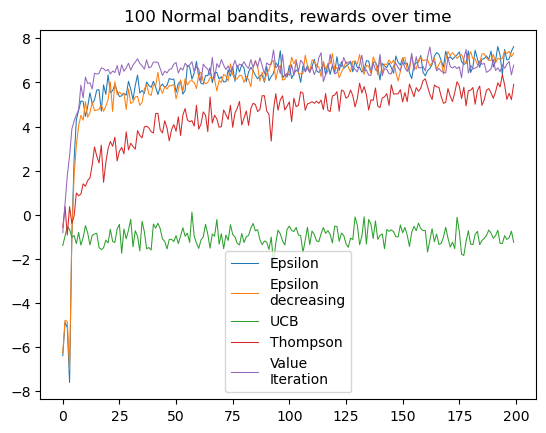

In [46]:
chart_data = [eps_avg_rewards, eps_decrease_avg_rewards, ucb_avg_rewards, thompson_avg_rewards, deep_value_avg_rewards]
chart_titles = ["Epsilon", "Epsilon\ndecreasing", "UCB", "Thompson", "Value\nIteration"]
chart_name = "100 Normal bandits, rewards over time"
show_rewards_chart_over_time(chart_data, chart_titles, chart_name)
save_rewards_chart_over_time(chart_data, chart_titles, chart_name)
chart_name = "100 Normal bandits, discounted rewards"
save_total_discounted_rewards_chart(chart_data, chart_titles, chart_name, 0.9)

In [21]:
def save_rewards_chart_over_time(chart_data, chart_titles, chart_name):
    fig, ax = plt.subplots()
    for i in range(len(chart_data)):
        plt.plot(chart_data[i], label=chart_titles[i], linewidth=0.75)
    
    plt.legend()
    plt.title(chart_name)
    fig.savefig("charts/" + chart_name + ".png")
    plt.close(fig)


def show_rewards_chart_over_time(chart_data, chart_titles, chart_name):
    fig, ax = plt.subplots()
    for i in range(len(chart_data)):
        plt.plot(chart_data[i], label=chart_titles[i], linewidth=0.75)
    
    plt.legend()
    plt.title(chart_name)

In [683]:
chart_data = [value_avg_rewards, gittins_avg_rewards]
chart_titles = ["Value \nIteration", "Gittins"]
chart_name = "X bandits - Y iterations"
save_rewards_chart_over_time(chart_data, chart_titles, chart_name)
chart_name = "X bandits - Y iterations - total discounted reward"
save_total_discounted_rewards_chart(chart_data, chart_titles, chart_name, 0.99)

In [662]:
chart_data = [eps_avg_rewards, eps_decrease_avg_rewards, ucb_avg_rewards, thompson_avg_rewards, value_avg_rewards]
chart_titles = ["Epsilon \nGreedy", "Epsilon \ndecreasing", "UCB", "Thompson \nSampling", "Value \nIteration"]
chart_name = "X bandits - Y iterations"
save_rewards_chart_over_time(chart_data, chart_titles, chart_name)
chart_name = "X bandits - Y iterations - total discounted reward"
save_total_discounted_rewards_chart(chart_data, chart_titles, chart_name, 0.99)

In [22]:
# Investigate notion of discounting future rewards and adding regret instead of looking at 
# expected pay-off per draw over the long run. 
def save_total_discounted_rewards_chart(chart_data, chart_titles, chart_name, discount_factor):
    discount_factor = 0.99

    results = []
    for i in range(len(chart_data)):
        disc_reward = np.sum(get_discounted_rewards(chart_data[i], discount_factor))
        results.append(disc_reward)
    
    algorithms = chart_titles
    
    unsorted_list = [(result, algorithm) for result, algorithm in 
                      zip(results, algorithms)]
    sorted_list = sorted(unsorted_list, reverse=True)
    
    algorithms_sorted = []
    values_sorted = []
    
    for i in sorted_list:
        algorithms_sorted += [i[1]]
        values_sorted += [i[0]]
    
    fig, ax = plt.subplots()
    
    bar_labels = algorithms_sorted
    
    ax.bar(algorithms_sorted, values_sorted, label=algorithms)
    
    ax.set_ylabel('Discounted total reward')
    ax.set_title('Algorithm comparison on discounted reward')
    ymin = 0.8 * np.min(results)
    ymax = 1.1 * np.max(results)
    ax.set_ylim([ymin, ymax])
    ax.bar_label(ax.containers[0], fmt="{:.1f}", label_type='edge')
    #plt.xticks(rotation=45)
    #ax.legend(title='Algorithm')
    plt.title(chart_name)
    fig.savefig('charts/' + chart_name + '.png')   # save the figure to file
    plt.close(fig)    # close the figure window

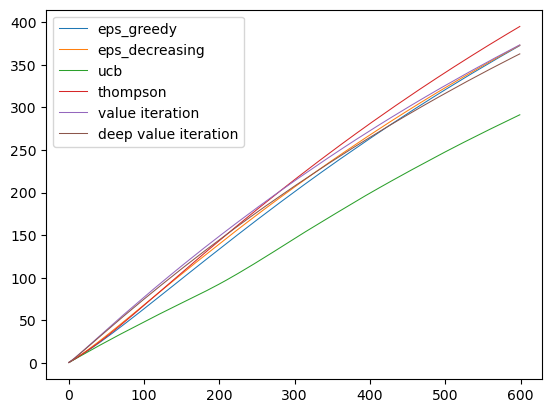

In [594]:
eps_disc_rewards = get_discounted_rewards(eps_avg_rewards, discount_factor)
eps_decrease_disc_rewards = get_discounted_rewards(eps_decrease_avg_rewards, discount_factor)
ucb_disc_rewards = get_discounted_rewards(ucb_avg_rewards, discount_factor)
thompson_disc_rewards = get_discounted_rewards(thompson_avg_rewards, discount_factor)

value_disc_rewards = get_discounted_rewards(value_avg_rewards, discount_factor)
deep_value_disc_rewards = get_discounted_rewards(deep_value_avg_rewards, discount_factor)

plt.plot(np.cumsum(eps_disc_rewards), label='eps_greedy', linewidth=0.75)
plt.plot(np.cumsum(eps_decrease_disc_rewards), label='eps_decreasing', linewidth=0.75)
plt.plot(np.cumsum(ucb_disc_rewards), label='ucb', linewidth=0.75)
plt.plot(np.cumsum(thompson_disc_rewards), label='thompson', linewidth=0.75)

plt.plot(np.cumsum(value_disc_rewards), label='value iteration', linewidth=0.75)

plt.plot(np.cumsum(deep_value_disc_rewards), label='deep value iteration', linewidth=0.75)

plt.legend()
plt.show()

In [669]:

number_bandits = [2, 3, 5, 10, 15, 20, 30, 50, 100, 200, 500]
number_range = [50, 100, 200, 500, 1000]

for num_bandit in number_bandits:
    for num_range in number_range:
        print(str(num_bandit) + " bandits - " + str(num_range) + " rounds")
        # Initialise MAB problem with these settings
        nr_bandits = num_bandit
        probs = np.random.rand(nr_bandits)
        payouts = [np.random.randint(1,10) for _ in range(nr_bandits)]
        bandit_type = "Bernoulli"
        mab = MultiArmedBandit(num_bandits = nr_bandits, probs = probs, payouts = payouts, bandit_type = bandit_type)

        nr_episodes = 1000
        episode_length = num_range

        # Initialise all algorithms
        eps_greedy = EpsilonGreedy(num_bandits = nr_bandits, eps = 0.05)
        eps_decreasing = EpsilonGreedy(num_bandits = nr_bandits, eps = 0.1, alpha = 0.99)
        ucb = UCB(num_bandits = nr_bandits)
        thompson = ThompsonSampling(num_bandits = nr_bandits)
        value_iteration = ValueIterationSecondUpdate(num_bandits = nr_bandits, max_iterations = 10000, calculate_value_function=True)

        # Run all models and calculate average rewards per episode
        eps_rewards = run_bandit(eps_greedy, episodes = nr_episodes, episode_length = episode_length)
        eps_avg_rewards = get_average_rewards(eps_rewards)
        
        eps_decrease_rewards = run_bandit(eps_decreasing, episodes = nr_episodes, episode_length = episode_length)
        eps_decrease_avg_rewards = get_average_rewards(eps_decrease_rewards)
        
        ucb_rewards = run_bandit(ucb, episodes = nr_episodes, episode_length = episode_length)
        ucb_avg_rewards = get_average_rewards(ucb_rewards)
        
        thompson_rewards = run_bandit(thompson, episodes = nr_episodes, episode_length = episode_length)
        thompson_avg_rewards = get_average_rewards(thompson_rewards)
        
        value_rewards = run_bandit(value_iteration, episodes = nr_episodes, episode_length = episode_length)
        value_avg_rewards = get_average_rewards(value_rewards)

        # Store results
        chart_data = [eps_avg_rewards, eps_decrease_avg_rewards, ucb_avg_rewards, thompson_avg_rewards, value_avg_rewards]
        chart_titles = ["Epsilon \nGreedy", "Epsilon \ndecreasing", "UCB", "Thompson \nSampling", "Value \nIteration"]
        chart_name = str(nr_bandits) + " bandits - " + str(episode_length) + " rounds"
        save_rewards_chart_over_time(chart_data, chart_titles, chart_name)
        chart_name = str(nr_bandits) + " bandits - " + str(episode_length) + " rounds- total discounted reward"
        save_total_discounted_rewards_chart(chart_data, chart_titles, chart_name, 0.99)

2 bandits - 50 rounds
2 bandits - 100 rounds
2 bandits - 200 rounds
2 bandits - 500 rounds
2 bandits - 1000 rounds
3 bandits - 50 rounds
3 bandits - 100 rounds
3 bandits - 200 rounds
3 bandits - 500 rounds
3 bandits - 1000 rounds
5 bandits - 50 rounds
5 bandits - 100 rounds
5 bandits - 200 rounds
5 bandits - 500 rounds
5 bandits - 1000 rounds
10 bandits - 50 rounds
10 bandits - 100 rounds
10 bandits - 200 rounds
10 bandits - 500 rounds
10 bandits - 1000 rounds
15 bandits - 50 rounds
15 bandits - 100 rounds
15 bandits - 200 rounds
15 bandits - 500 rounds
15 bandits - 1000 rounds
20 bandits - 50 rounds
20 bandits - 100 rounds
20 bandits - 200 rounds
20 bandits - 500 rounds
20 bandits - 1000 rounds
30 bandits - 50 rounds
30 bandits - 100 rounds
30 bandits - 200 rounds
30 bandits - 500 rounds
30 bandits - 1000 rounds
50 bandits - 50 rounds
50 bandits - 100 rounds
50 bandits - 200 rounds
50 bandits - 500 rounds
50 bandits - 1000 rounds
100 bandits - 50 rounds
100 bandits - 100 rounds
100 ba

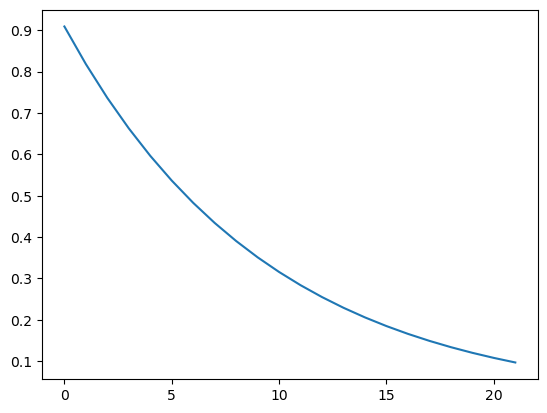

In [193]:
plt.plot(value_iteration.differences_in_value_function)
plt.show()

In [79]:


iterables = []
for i in range(4*2):
    iterables.append(np.linspace(1,10,10))
#iterables = [ np.linspace(1,10,10), np.linspace(1,10,10), np.linspace(1,10,10) ]
result = []
for t in itertools.product(*iterables):
    result.append(t)
np.array(result)

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  2.],
       [ 1.,  1.,  1., ...,  1.,  1.,  3.],
       ...,
       [10., 10., 10., ..., 10., 10.,  8.],
       [10., 10., 10., ..., 10., 10.,  9.],
       [10., 10., 10., ..., 10., 10., 10.]])

In [108]:
np.random.rand(nr_bandits)
np.array([1.0, 0.0])

array([1., 0.])

Number of possible states per bandit: 160801
Value function converged after 687 iterations.


In [583]:

value_iteration = ValueIterationSecondUpdate(num_bandits = nr_bandits, max_iterations = 100000, calculate_value_function=True)

#value_iteration.choose()

Number of possible states per bandit: 361201
Value function converged after 688 iterations.


In [289]:
value_iteration.choose()
#value_iteration.process_choice(2, 1)

2

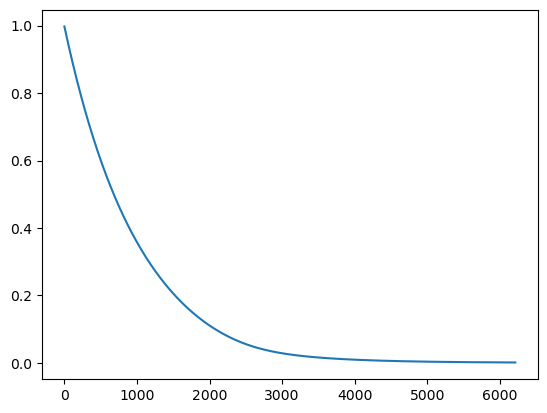

In [542]:
# Decrease from ~15 to ~14 between 585 and 625
#plt.plot(value_iteration_update.value_function[585:625])
#plt.plot(value_iteration.value_function)
plt.plot(value_iteration.differences_in_value_function)
#value_iteration_update.differences_in_value_function

In [484]:
from matplotlib import cm

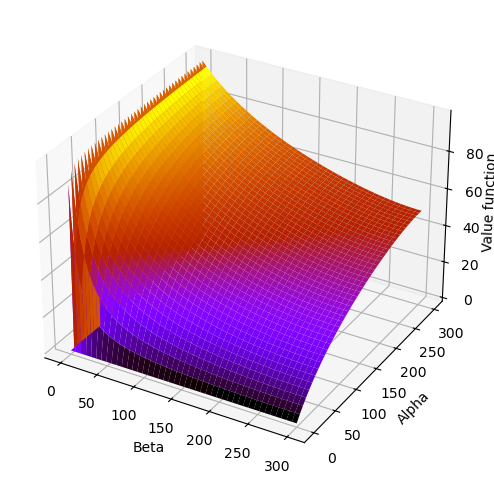

In [671]:
t = value_iteration.value_function

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection="3d")

z = t

y = np.arange(len(z))
x = np.arange(len(z[0]))

(x ,y) = np.meshgrid(x,y)

ax.plot_surface(x,y,z, cmap=cm.gnuplot,
                       linewidth=0.1, antialiased=True)

ax.zaxis.labelpad=-1.5
ax.set_zlabel("Value function")
ax.set_ylabel("Alpha")
ax.set_xlabel("Beta")

plt.show()
fig.savefig("test.png")

In [13]:


surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [435]:
# Initialize approximator with state and action dimensions
#approximator = DeepValueFunctionApproximator(num_bandits=nr_bandits, calculate_value_function=True)
approximator = DeepValueFunctionOptimized(num_bandits=nr_bandits, calculate_value_function=True)

# Predict the value for a given state
#print(approximator.predict([0]))  # Example prediction for state 0

Iteration 0, Loss: 0.40347346663475037


In [50]:

nr_bandits = 20

value_depth_range = [600]

value_iteration = ValueIterationSecondUpdate(num_bandits = nr_bandits, max_iterations = 10000, calculate_value_function=True)

for value_depth in value_depth_range:
    probs = np.random.rand(nr_bandits)
    payouts = [np.random.randint(1,10) for _ in range(nr_bandits)]
    bandit_type = "Bernoulli"
    mab = MultiArmedBandit(num_bandits = nr_bandits, probs = probs, payouts = payouts, bandit_type = bandit_type)

    nr_episodes = 1000
    episode_length = 200

    # Initialise deep learning algorithms
    #approximator = DeepValueFunctionOptimized(num_bandits=nr_bandits, calculate_value_function=True, 
    #                                          time_limit=60, max_calc_range=value_depth)

    approximator = DeepValueFunctionTest(num_bandits=nr_bandits, calculate_value_function=True, 
                                              max_calc_range=value_depth)

    # Run models and calculate average rewards per episode
    value_rewards = run_bandit(value_iteration, episodes = nr_episodes, episode_length = episode_length)
    value_avg_rewards = get_average_rewards(value_rewards)

    deep_value_rewards = run_bandit(approximator, episodes = nr_episodes, episode_length = episode_length)
    deep_value_avg_rewards = get_average_rewards(deep_value_rewards)

    # Store results
    chart_data = [value_avg_rewards, deep_value_avg_rewards]
    chart_titles = ["Value \nIteration", "Deep Value\nIteration"]
    chart_name = str(value_depth) + " training time - 2"
    save_rewards_chart_over_time(chart_data, chart_titles, chart_name)
    chart_name = str(value_depth) + " training time - total discounted reward - 2"
    save_total_discounted_rewards_chart(chart_data, chart_titles, chart_name, 0.99)


Iteration 0, Loss: 2.6975412368774414
Iteration 100, Loss: 0.00566357746720314
Iteration 200, Loss: 0.004731588996946812
Iteration 300, Loss: 0.0048513528890907764
Iteration 400, Loss: 0.003522814717143774
Iteration 500, Loss: 0.0035707103088498116
Iteration 600, Loss: 0.0035439259372651577
Iteration 700, Loss: 0.0034182933159172535
Iteration 800, Loss: 0.0032076197676360607
Iteration 900, Loss: 0.0034992198925465345
Iteration 1000, Loss: 0.0032535444479435682
Iteration 1100, Loss: 0.003272007219493389
Iteration 1200, Loss: 0.0038071670569479465
Iteration 1300, Loss: 0.0035410444252192974
Iteration 1400, Loss: 0.0026730848476290703
Iteration 1500, Loss: 0.002552398946136236
Iteration 1600, Loss: 0.0033408671151846647
Iteration 1700, Loss: 0.003047347068786621
Iteration 1800, Loss: 0.0030468679033219814
Iteration 1900, Loss: 0.003355343360453844
Iteration 2000, Loss: 0.003155745565891266
Iteration 2100, Loss: 0.003193083219230175
Iteration 2200, Loss: 0.0028254471253603697
Iteration 230

In [53]:
nr_bandits = 20

time_value = 5
max_calc_time = 200

value_iteration = ValueIterationSecondUpdate(num_bandits = nr_bandits, max_iterations = 10000, calculate_value_function=True)




NameError: name 'num_bandit' is not defined

In [60]:
# Initialise deep learning algorithms

approximator = DeepValueFunctionTest(num_bandits=nr_bandits, calculate_value_function=True, 
                                    max_calc_range=max_calc_time, use_coreml=True)

TypeError: DeepValueFunctionTest.__init__() got an unexpected keyword argument 'use_coreml'

In [ ]:
probs = np.random.rand(nr_bandits)
payouts = [np.random.randint(1,10) for _ in range(nr_bandits)]
bandit_type = "Bernoulli"
mab = MultiArmedBandit(num_bandits = nr_bandits, probs = probs, payouts = payouts, bandit_type = bandit_type)

nr_episodes = 1000
episode_length = 200

# Run value iteration model and calculate average rewards per episode
value_rewards = run_bandit(value_iteration, episodes = nr_episodes, episode_length = episode_length)
value_avg_rewards = get_average_rewards(value_rewards)

In [ ]:
deep_value_rewards = run_bandit(approximator, episodes = nr_episodes, episode_length = episode_length)
deep_value_avg_rewards = get_average_rewards(deep_value_rewards)

In [677]:



# Store results
chart_data = [value_avg_rewards, deep_value_avg_rewards]
chart_titles = ["Value \nIteration", "Deep Value\nIteration"]
chart_name = str(time_value) + " training time"
save_rewards_chart_over_time(chart_data, chart_titles, chart_name)
chart_name = str(time_value) + " training time - total discounted reward"
save_total_discounted_rewards_chart(chart_data, chart_titles, chart_name, 0.99)

Iteration 0, Loss: 0.1626594066619873


In [678]:
value_avg_rewards = get_average_rewards(value_rewards)
deep_value_avg_rewards = get_average_rewards(deep_value_rewards)
chart_data = [value_avg_rewards, deep_value_avg_rewards]
chart_titles = ["Value \nIteration", "Deep Value\nIteration"]
chart_name = str(time_value) + " training time"
save_rewards_chart_over_time(chart_data, chart_titles, chart_name)
chart_name = str(time_value) + " training time - total discounted reward"
save_total_discounted_rewards_chart(chart_data, chart_titles, chart_name, 0.99)

In [258]:
deep_value_rewards = run_bandit(approximator, episodes = nr_episodes, episode_length = episode_length)
deep_value_avg_rewards = get_average_rewards(deep_value_rewards)

In [259]:
eps_greedy = EpsilonGreedy(num_bandits = nr_bandits, eps = 0.05)

thompson = ThompsonSampling(num_bandits = nr_bandits)
#value_iteration = ValueIterationUpdate(num_bandits = nr_bandits, max_iterations = 200)

eps_rewards = run_bandit(eps_greedy, episodes = nr_episodes, episode_length = episode_length)
eps_avg_rewards = get_average_rewards(eps_rewards)

thompson_rewards = run_bandit(thompson, episodes = nr_episodes, episode_length = episode_length)
thompson_avg_rewards = get_average_rewards(thompson_rewards)

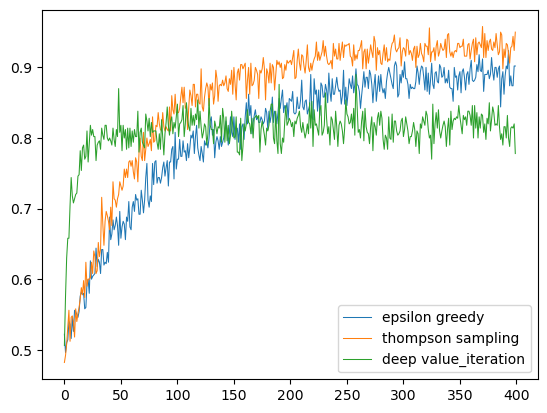

In [463]:
plt.plot(eps_avg_rewards, label='epsilon greedy', linewidth=0.75)
plt.plot(thompson_avg_rewards, label='thompson sampling', linewidth=0.75)
plt.plot(deep_value_avg_rewards, label='deep value_iteration', linewidth=0.75)
plt.legend()
plt.show()

In [224]:
#torch.save(approximator.model.state_dict(), "model_weights.pth")
approximator.model.load_state_dict(torch.load("model_weights.pth", map_location=approximator.device))
approximator.model.to(approximator.device)

Sequential(
  (0): Linear(in_features=6, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=1, bias=True)
)

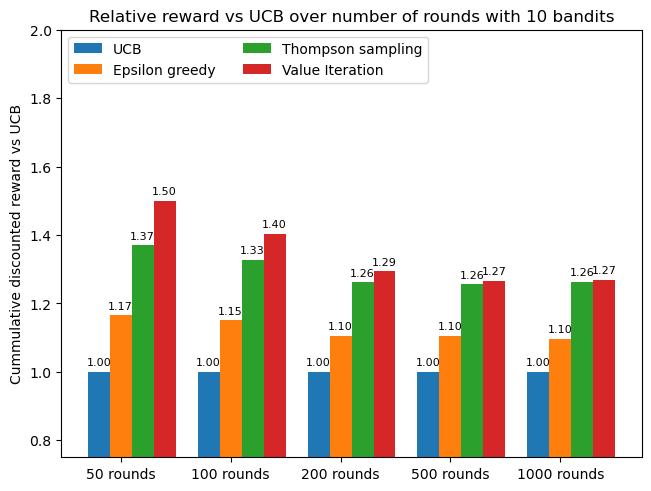

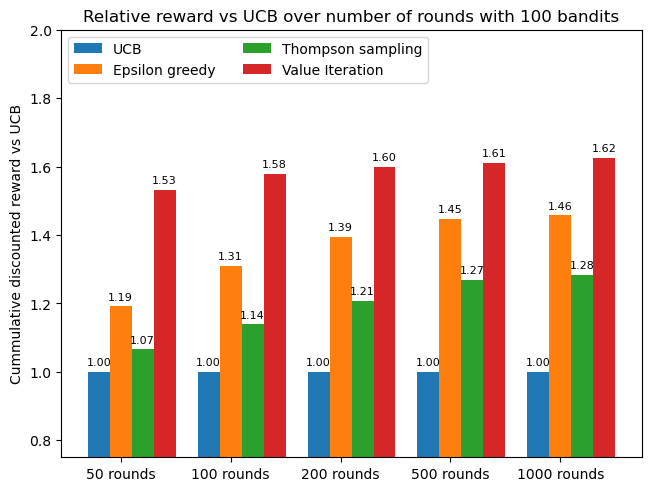

In [47]:
# 10 bandits values

value_iteration_total_rewards = np.array([30.0, 50.1, 69.2, 79.6, 80.2])
thompson_sampling_total_rewards = np.array([27.4, 47.4, 67.5, 79.0, 79.8])
epsilon_greedy_total_rewards = np.array([23.3, 41.1, 59.1, 69.5, 69.3])
ucb_total_rewards = np.array([20.0, 35.7, 53.5, 62.9, 63.2])

number_rounds = [50, 100, 200, 500, 1000]

# Relative performance vs UCB

ucb_relative = ucb_total_rewards / ucb_total_rewards
epsilon_relative = epsilon_greedy_total_rewards / ucb_total_rewards
thompson_relative = thompson_sampling_total_rewards / ucb_total_rewards
value_iteration_relative = value_iteration_total_rewards / ucb_total_rewards

#fig, ax = plt.subplots()

labels = []
for rounds in number_rounds:
    label = str(rounds) + " rounds"
    labels.append(label)

bar_labels = labels

plot_values = {
    'UCB': ucb_relative,
    'Epsilon greedy': epsilon_relative,
    'Thompson sampling': thompson_relative,
    'Value Iteration': value_iteration_relative
}

x = np.arange(len(bar_labels))  # the label locations
width = 0.20  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for algorithm, value in plot_values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, value, width, label=algorithm)
    ax.bar_label(rects, padding=3, fmt="{:.2f}", label_type='edge', fontsize=8)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Cummulative discounted reward vs UCB')
ax.set_title('Relative reward vs UCB over number of rounds with 10 bandits')
ax.set_xticks(x + width, bar_labels)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0.75, 2)

plt.show()
fig.savefig('charts/comparison_ucb_10_bandits.png')   # save the figure to file
plt.close(fig)    # close the figure window

# 100 bandits values

value_iteration_total_rewards = np.array([30.5, 49.9, 69.4, 80.1, 80.6])
thompson_sampling_total_rewards = np.array([21.2, 36.0, 52.4, 63.1, 63.7])
epsilon_greedy_total_rewards = np.array([23.7, 41.4, 60.5, 71.9, 72.3])
ucb_total_rewards = np.array([19.9, 31.6, 43.4, 49.7, 49.6])

ucb_relative = ucb_total_rewards / ucb_total_rewards
epsilon_relative = epsilon_greedy_total_rewards / ucb_total_rewards
thompson_relative = thompson_sampling_total_rewards / ucb_total_rewards
value_iteration_relative = value_iteration_total_rewards / ucb_total_rewards

plot_values = {
    'UCB': ucb_relative,
    'Epsilon greedy': epsilon_relative,
    'Thompson sampling': thompson_relative,
    'Value Iteration': value_iteration_relative
}

x = np.arange(len(bar_labels))  # the label locations
width = 0.20  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for algorithm, value in plot_values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, value, width, label=algorithm)
    ax.bar_label(rects, padding=3, fmt="{:.2f}", label_type='edge', fontsize=8)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Cummulative discounted reward vs UCB')
ax.set_title('Relative reward vs UCB over number of rounds with 100 bandits')
ax.set_xticks(x + width, bar_labels)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0.75, 2)

plt.show()
fig.savefig('charts/comparison_ucb_100_bandits.png')   # save the figure to file
plt.close(fig)    # close the figure window

# Pricing tests

In [21]:
# Define possible price points
price_points = [5, 10, 15, 20, 25]  # Example prices

# Initialize the PricingValueIteration class
pricing_vi = PricingValueIteration(price_points=price_points, max_iterations=1000, calculate_value_function=True)




Value function converged after 995 iterations.


In [ ]:
# Simulate customer interactions
num_interactions = 100
for _ in range(num_interactions):
    # Choose the optimal price to offer
    chosen_price = pricing_vi.choose()

    # Simulate customer response (buy or not buy)
    # For example, assume probability of purchase decreases with price
    true_purchase_probabilities = [0.8, 0.6, 0.4, 0.2, 0.1]
    price_index = price_points.index(chosen_price)
    purchase_probability = true_purchase_probabilities[price_index]
    purchase = np.random.binomial(1, purchase_probability)

    # Process the outcome
    pricing_vi.process_choice(chosen_price, purchase)

# Print the average revenue
pricing_vi.print_average_reward()